## Data Exploration (ML50-2023) - Mateus

### __Importing libraries__

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# -------------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [72]:
# Data path : ../Data/test.csv
test_path = os.path.join('..', 'Data', 'test.csv')
train_path = os.path.join('..', 'Data', 'train.csv')
icd_9_path = os.path.join('..', 'Data', 'icd9_codes.txt')

# Read data
test = pd.read_csv(test_path, index_col='encounter_id')
train = pd.read_csv(train_path, index_col='encounter_id')
icd_9 = pd.read_csv(icd_9_path, sep=',', encoding='ISO-8859-1', index_col=0)
icd_9['3 digit code'] = icd_9.index.str[:3]
icd_9.set_index('3 digit code', inplace=True)
# Delete duplicates in the index
icd_9 = icd_9[~icd_9.index.duplicated(keep='first')]

test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
data = pd.concat([train, test], axis=0)

# Change the target variable to 0 and 1
data['readmitted_binary'] = data['readmitted_binary'].map({'No': 0, 'Yes': 1})

### __I. Selecting the data__
- Check for non-varying features 
- Intuition-based feature selection
- Changing variable names for simplicity

In [73]:
data.sort_values(by='encounter_id', inplace=True)
data.head(5).T

encounter_id,100000,100020,100022,100060,100076
country,USA,USA,USA,USA,USA
patient_id,93450780,23711949,5010480,2592378,24744411
race,Caucasian,Caucasian,Caucasian,?,Caucasian
gender,Male,Female,Female,Male,Female
age,[60-70),[40-50),[50-60),[60-70),[90-100)
weight,?,?,?,?,?
payer_code,CP,HM,UN,UN,MC
outpatient_visits_in_previous_year,0,0,0,0,0
emergency_visits_in_previous_year,0,0,0,0,0
inpatient_visits_in_previous_year,0,0,0,1,0


1. Non varying features

In [74]:
# We can immediately see that there is only one country, USA, so we can drop that non-informative column
data.drop('country', axis=1, inplace=True)

2. Gender is probably not relevant, so let's check for independence between gender and the target variable.

In [75]:
# Perform a chi-sq test for independence between the gender and the target variable
pre_contingency = data.groupby('gender')['readmitted_binary'].value_counts()
table = pre_contingency.unstack().drop('Unknown/Invalid', axis=0)

chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.121 > 0.05
We cannot reject the null hypothesis, the variables are independent


In [76]:
# We, therefore drop the gender column
gender = data['gender']
data.drop('gender', axis=1, inplace=True)

3. Lets do the same for race

In [77]:
table = data.groupby('race')['readmitted_binary'].value_counts().unstack()
table = table.drop('?', axis=0)
chi2, p, dof, expected = chi2_contingency(table)

# Print if we can reject the null hypothesis
print('p-value: ', round(p,3), '> 0.05' if p > 0.05 else '< 0.05')
if p < 0.05:
    print('We reject the null hypothesis, the variables are dependent')
else:
    print('We cannot reject the null hypothesis, the variables are independent')

p-value:  0.039 < 0.05
We reject the null hypothesis, the variables are dependent


4. Lets change long variable names for simplicity

In [78]:
mapper = {
    'outpatient_visits_in_previous_year': 'outvisits',
    'inpatient_visits_in_previous_year': 'invisits',
    'emergency_visits_in_previous_year': 'emvisits',
    'change_in_meds_during_hospitalization': 'change_meds',
    'prescribed_diabetes_meds': 'diabetes_meds',
    'length_of_stay_in_hospital': 'length_stay',
    'number_of_medications': 'num_meds',
    'primary_diagnosis': 'diag_1',
    'secondary_diagnosis': 'diag_2',
    'additional_diagnosis': 'diag_3',
    'number_diagnoses': 'num_diag',
    'number_lab_tests': 'num_tests',
    'discharge_disposition': 'disposition'
}

data.rename(columns=mapper, inplace=True)

In [79]:
data.T

encounter_id,100000,100020,100022,100060,100076,100078,100080,100087,100096,100108,...,999897,999906,999911,999928,999940,999944,999953,999966,999968,999980
patient_id,93450780,23711949,5010480,2592378,24744411,23188977,18852453,13016943,23604354,30312180,...,85011156,86412609,93065292,42277347,94147587,38851947,96923772,88691724,95180958,67469157
race,Caucasian,Caucasian,Caucasian,?,Caucasian,Caucasian,NaN,AfricanAmerican,Caucasian,Caucasian,...,Caucasian,Caucasian,Caucasian,NaN,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian
age,[60-70),[40-50),[50-60),[60-70),[90-100),[60-70),[40-50),[70-80),[60-70),[80-90),...,[60-70),[60-70),[70-80),[50-60),[90-100),[70-80),[70-80),[80-90),[60-70),[50-60)
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
payer_code,CP,HM,UN,UN,MC,MC,HM,MC,MC,MC,...,MC,MC,MC,HM,MC,MD,MC,MC,MC,BC
outvisits,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,4,0,0
emvisits,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
invisits,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,3,0
admission_type,Emergency,Not Available,Urgent,Urgent,Emergency,Urgent,Urgent,Emergency,Elective,Not Available,...,Urgent,Emergency,Urgent,Elective,Elective,Elective,Emergency,Emergency,Emergency,Emergency
medical_specialty,Emergency/Trauma,Family/GeneralPractice,InternalMedicine,Podiatry,Family/GeneralPractice,InternalMedicine,InternalMedicine,Family/GeneralPractice,InternalMedicine,?,...,?,?,Surgery-General,?,?,?,?,?,?,?


### __II. Feature encoding__
- This is the first step for our analysis, as we need to transform the categorical variables/binary into numerical ones. We will use the __LabelEncoder__ from the __sklearn.preprocessing__ library to do so.

- We will also convert intervals to middle values, so we can treat them as numerical variables.

- Medication is not a useful feature as it is, so we will create many new dummy features from it.

0. Diagnosis codes (ICD9) - 3 digits, are not understandable, so we will convert them to their respective disease names. This is actually decoding, but we will need this later on

In [80]:
# Adding a 0 to the codes that have only two digits
data['diag_1'] = data['diag_1'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_1'] = data['diag_1'].apply(lambda x: '00' + x if len(x) == 1 and x!='?' else x)
data['diag_1'] = data['diag_1'].apply(lambda x: x if len(x) == 3 else x[:3])
data['diag_2'] = data['diag_2'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_2'] = data['diag_2'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
data['diag_2'] = data['diag_2'].apply(lambda x: x if len(x) == 3 else x[:3])
data['diag_3'] = data['diag_3'].apply(lambda x: '0' + x if len(x) == 2 else x)
data['diag_3'] = data['diag_3'].apply(lambda x: '00' + x if len(x) == 1 and x != '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x: x if len(x) == 3 else x[:3])

# This will ease our work later on
data['diag_1_description'] = data['diag_1'].map(icd_9['long_description'])
data['diag_2_description'] = data['diag_2'].map(icd_9['long_description'])
data['diag_3_description'] = data['diag_3'].map(icd_9['long_description'])

1. Encoding the variables - to binary

In [81]:
# Transform the target variable, and two meds features into a binary variable
data['diabetes_meds'] = data['diabetes_meds'].map({'No': 0, 'Yes': 1})
data['change_meds'] = data['change_meds'].map({'No': 0, 'Ch': 1})

2. Encoding the variables - to class

In [82]:
# First we need to convert ? to NaN
# Print which features contain '?'
print('Features with ? : ', data.columns[data.isin(['?']).any()].tolist())

# Replace ? with NaN
data.replace('?', np.nan, inplace=True)

Features with ? :  ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


Admission_type and admission_source contain Not Available values, so we will replace them with Nan

In [83]:
# Change Nan to Not Available
data['admission_type'] = data['admission_type'].fillna('Not Available')
data['admission_source'] = data['admission_source'].fillna(' Not Available')

In [84]:
# Encode the following variables: race, payer_code, admission_type, medical_specialty, discharge_disposition, admission_source
features_to_encode = ['payer_code', 'admission_type', 'medical_specialty', 'disposition', 'admission_source']
encoder_dict = {features_to_encode[i]: LabelEncoder() for i in range(len(features_to_encode))}
for feature in features_to_encode:
    encoder_dict[feature].fit(data[feature])
    data[feature] = encoder_dict[feature].transform(data[feature].values)
    # Convert the class of Nan to Nan, which is always the last for classes that are not admission_type and admission_source
    if feature not in ['admission_type', 'admission_source']:
        data[feature].replace(encoder_dict[feature].transform(encoder_dict[feature].classes_)[-1], np.nan, inplace=True)
    print(f'{feature} classes: ', dict(zip(encoder_dict[feature].classes_, encoder_dict[feature].transform(encoder_dict[feature].classes_))))

payer_code classes:  {'BC': 0, 'CH': 1, 'CM': 2, 'CP': 3, 'DM': 4, 'FR': 5, 'HM': 6, 'MC': 7, 'MD': 8, 'MP': 9, 'OG': 10, 'OT': 11, 'PO': 12, 'SI': 13, 'SP': 14, 'UN': 15, 'WC': 16, nan: 17}
admission_type classes:  {'Elective': 0, 'Emergency': 1, 'Newborn': 2, 'Not Available': 3, 'Not Mapped': 4, 'Trauma Center': 5, 'Urgent': 6}
medical_specialty classes:  {'AllergyandImmunology': 0, 'Anesthesiology': 1, 'Anesthesiology-Pediatric': 2, 'Cardiology': 3, 'Cardiology-Pediatric': 4, 'DCPTEAM': 5, 'Dentistry': 6, 'Dermatology': 7, 'Emergency/Trauma': 8, 'Endocrinology': 9, 'Endocrinology-Metabolism': 10, 'Family/GeneralPractice': 11, 'Gastroenterology': 12, 'Gynecology': 13, 'Hematology': 14, 'Hematology/Oncology': 15, 'Hospitalist': 16, 'InfectiousDiseases': 17, 'InternalMedicine': 18, 'Nephrology': 19, 'Neurology': 20, 'Neurophysiology': 21, 'Obsterics&Gynecology-GynecologicOnco': 22, 'Obstetrics': 23, 'ObstetricsandGynecology': 24, 'Oncology': 25, 'Ophthalmology': 26, 'Orthopedics': 27, 

3. Transforming age and weight into numerical variables

In [85]:
data['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, inplace=True)
data['weight'].replace({'[0-25)': 12.5, '[25-50)': 37.5, '[50-75)': 62.5, '[75-100)': 87.5, '[100-125)': 112.5, '[125-150)': 137.5, '[150-175)': 162.5, '[175-200)': 187.5, '>200': 225}, inplace=True)

4. Transforming medication into dummy variables

In [86]:
# Transforming the medication list into many dummy variables
meds = data['medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    meds.columns = meds.columns.str.replace(re.escape(symbol), '', regex=True)

Removing dupplicates

In [87]:
unique_cols = meds.columns.unique()
new_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(meds[col]) == pd.Series:
        new_meds[col] = meds[col]
    else:
        new_meds[col] = meds[col].max(axis=1)
meds = new_meds

# Lets delete combinations of drugs
for col in meds.columns.unique():
    if '-' in col:
        meds.drop(col, axis=1, inplace=True)

# Rename the last column to avoid confusion
meds.rename(columns={'' : 'no_meds'}, inplace=True)

meds.head(2)

,acarbose,chlorpropamide,glimepiride,glipizide,glyburide,insulin,miglitol,nateglinide,pioglitazone,repaglinide,rosiglitazone,tolazamide,tolbutamide,troglitazone,acetohexamide,metformin,no_meds
encounter_id,,,,,,,,,,,,,,,,,
100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100020,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Adding the new features to the dataset

In [88]:
data = pd.concat([data,meds], axis=1)
# Deleting the medication column
data.drop('medication', axis=1, inplace=True)

### __III. Understanding the data__
- For numerical features lets get the correlation to the target variable and the correlation between the features
- For other variables, lets get the representation of each class in the target variable

In [117]:
# Saving a copy 
data_II = data.copy()
numerical_features = ['age', 'weight', 'outvisits', 'emvisits', 'invisits', 'average_pulse_bpm', 'length_stay', 'num_tests', 'non_lab_procedures', 'num_meds', 'num_diag']
binary_features = ['change_meds', 'diabetes_meds', 'no_meds', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acarbose', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'insulin', 'miglitol', 'nateglinide', 'pioglitazone', 'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone', 'acetohexamide', 'metformin']
categorical_features = set(data.columns) - set(numerical_features) - set(binary_features) - set(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'patient_id'])

1. Numerical features

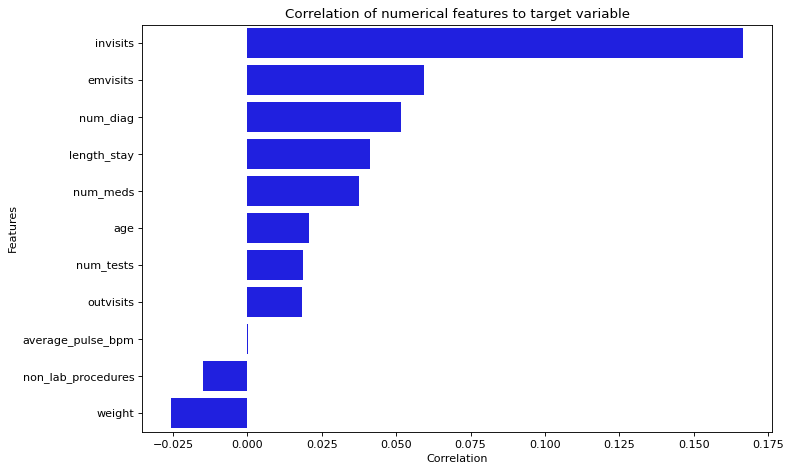

In [118]:
# Lets get the variables correlation to the target variable
correl = data[numerical_features+['readmitted_binary']].corr(method='pearson')['readmitted_binary'].sort_values(ascending=False)
correl.drop('readmitted_binary', inplace=True)

# Lets plot the correlation
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=correl.values, y=correl.index, color='b')
plt.title('Correlation of numerical features to target variable')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

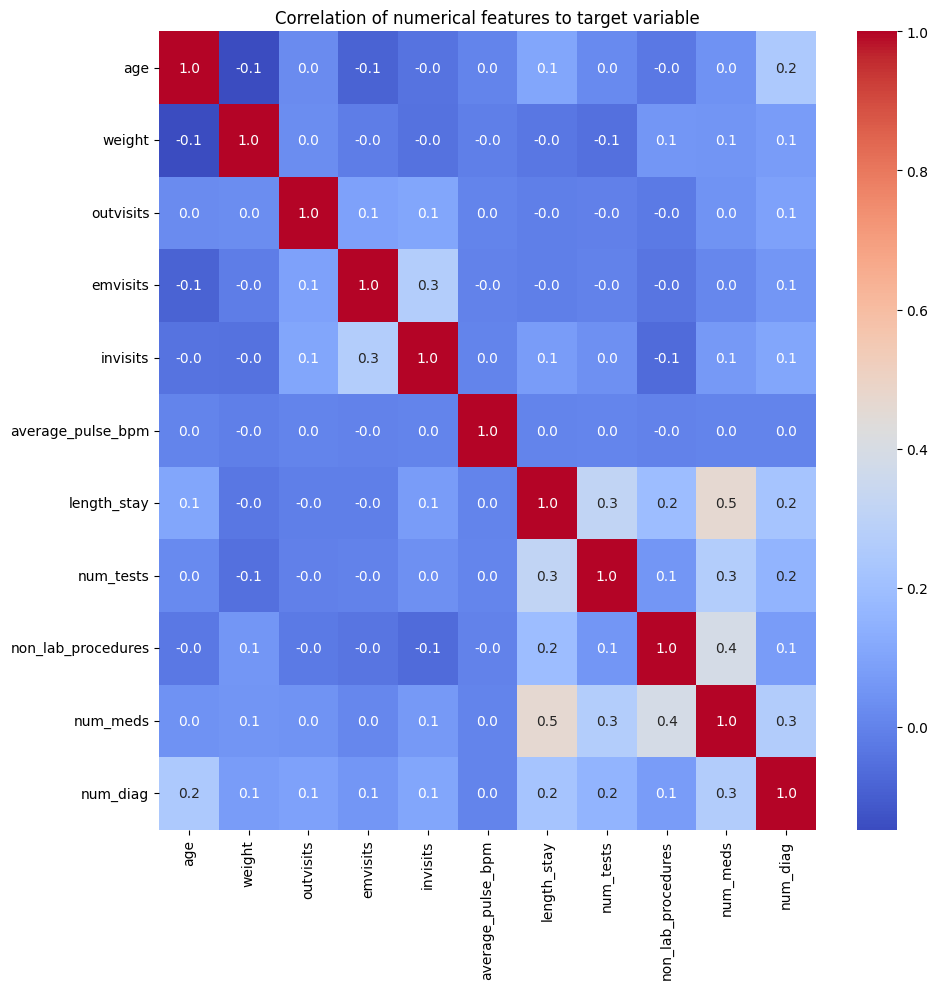

In [119]:
# Lets plot the heatmap of the correlation for the numerical features
plt.figure(figsize=(10,10), dpi=100)
sns.heatmap(data[numerical_features].corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation of numerical features to target variable')
plt.tight_layout()
plt.show()

Average pulse (bpm) seems to be completely independent from the target variable, and from the other features. We will drop it.

In [120]:
average_pulse_bpm = data['average_pulse_bpm']
data = data.drop(['average_pulse_bpm'], axis=1)

2. Categorical features (except for diagnosis)

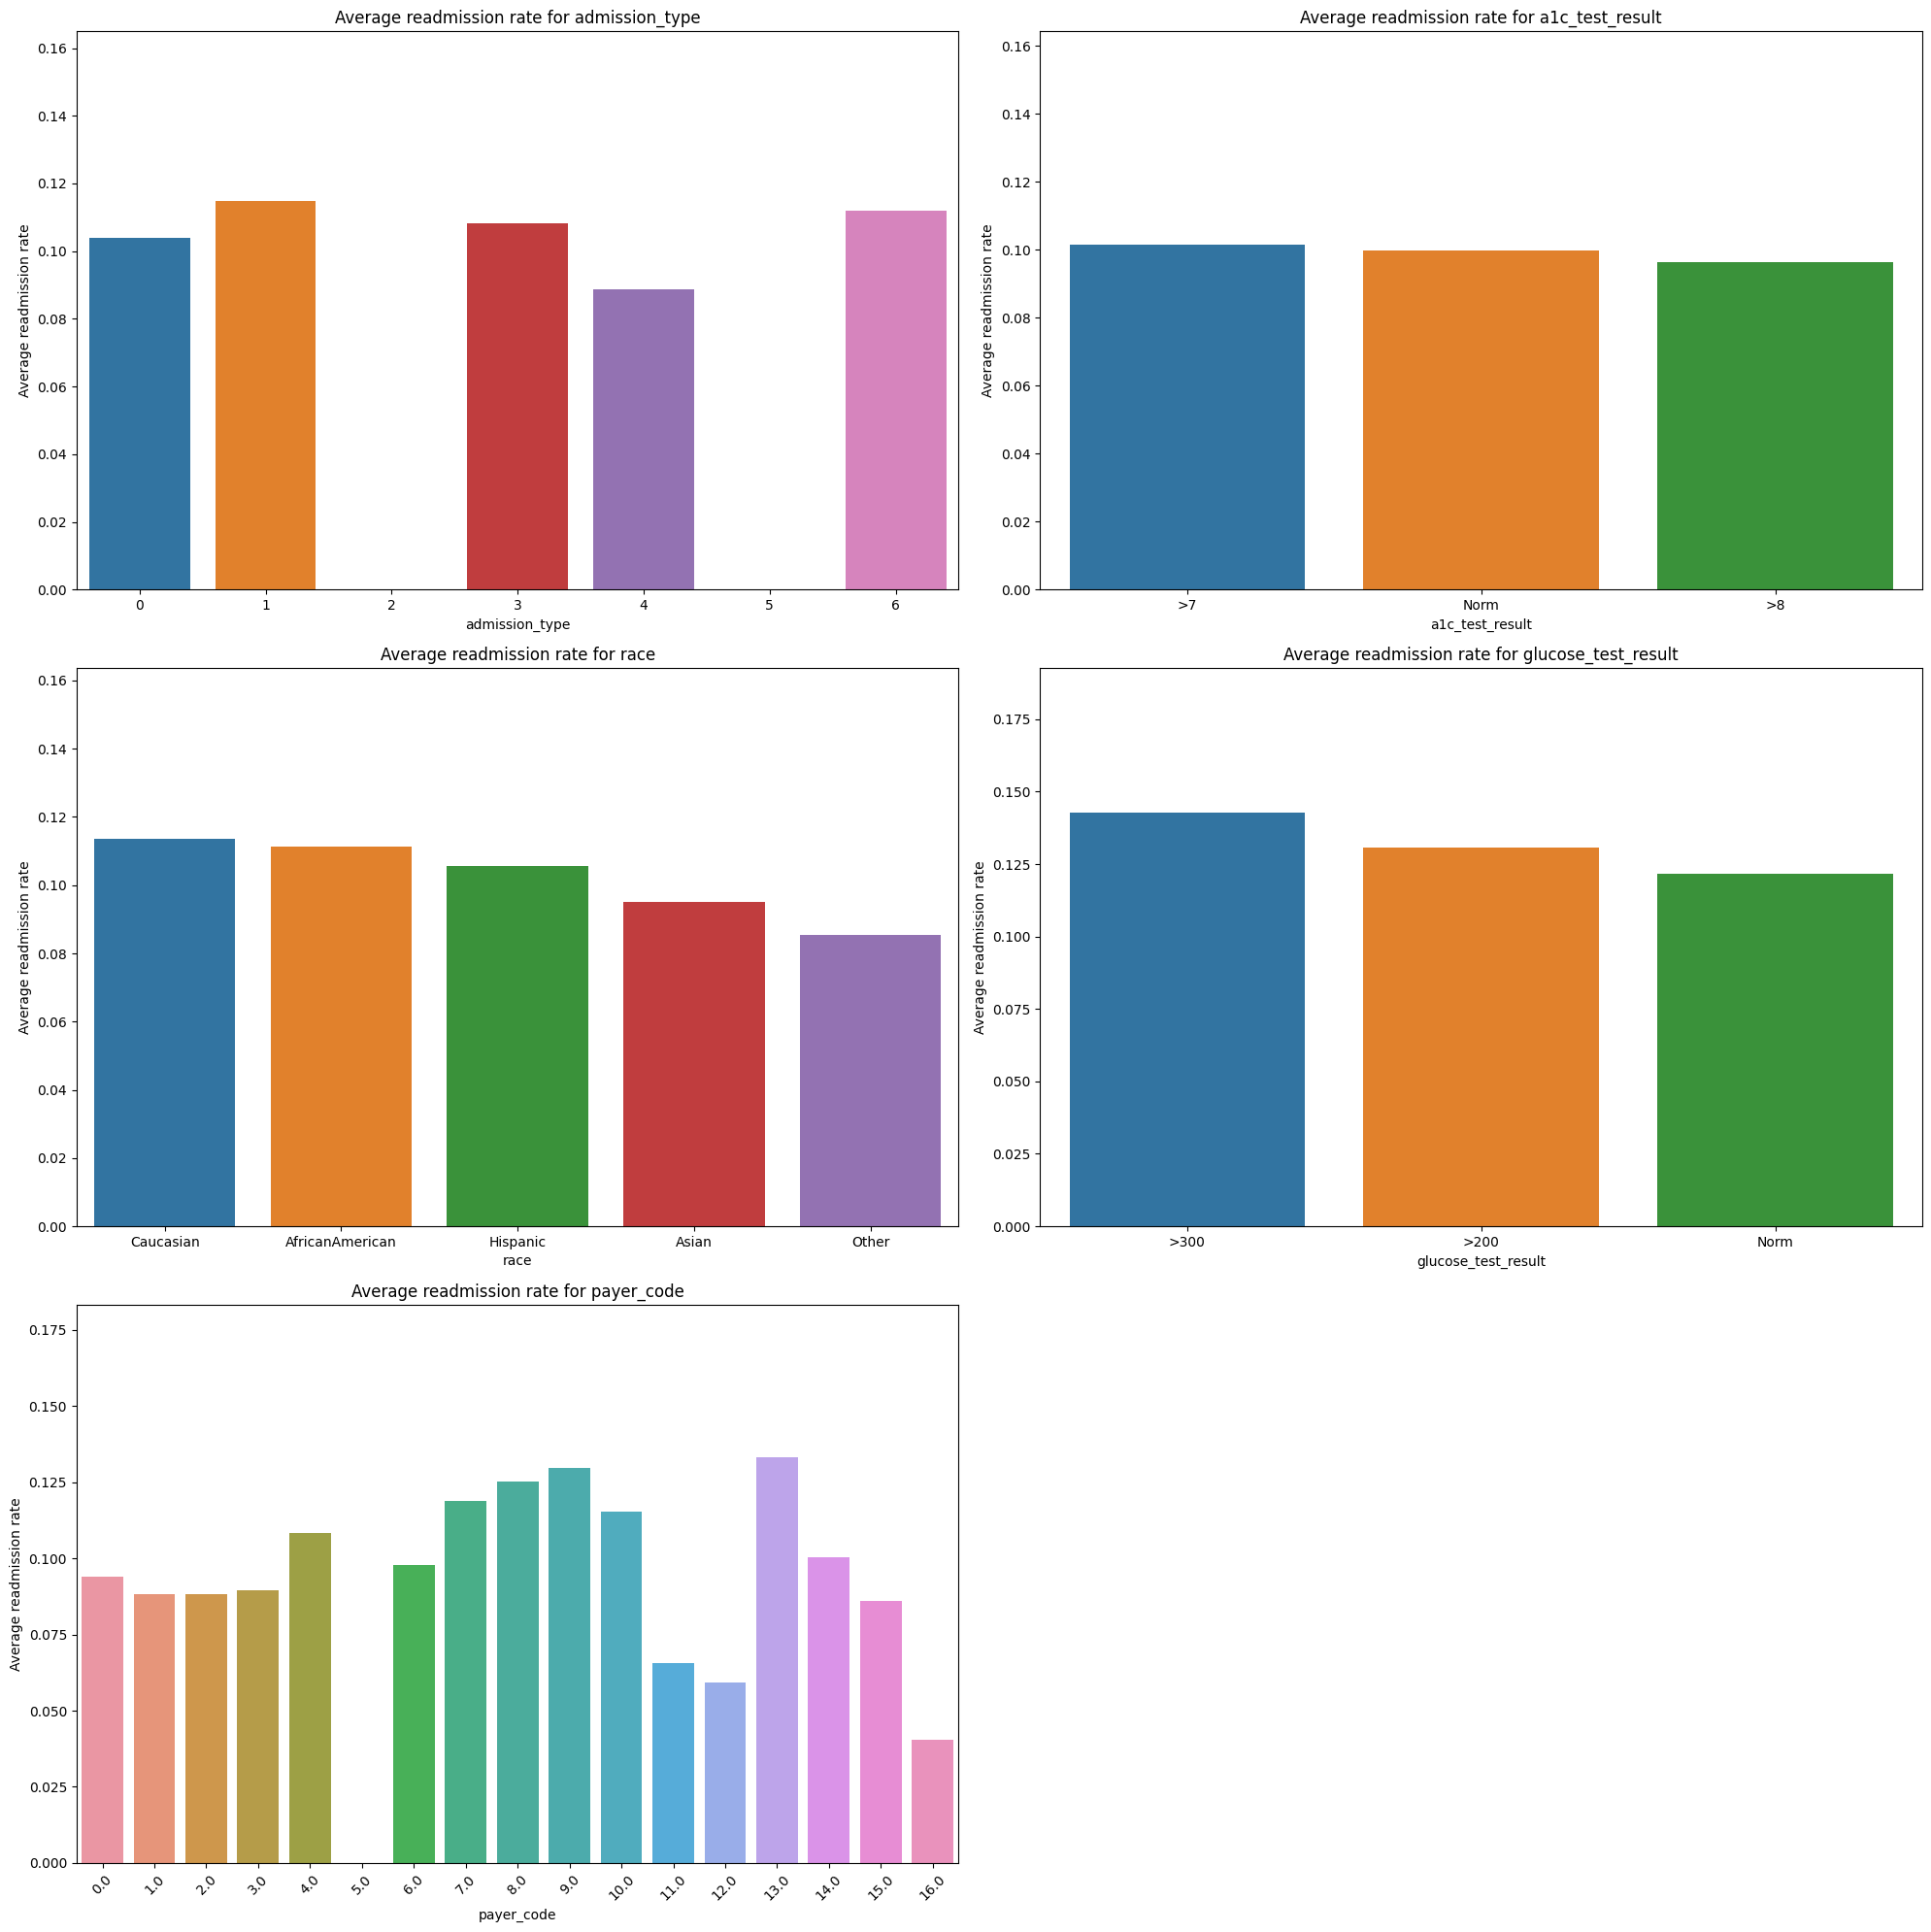

In [121]:
# Lets plot how different categorical values affect the target variable
fig, ax = plt.subplots(3,2, figsize=(20,20))
to_plot = set(categorical_features) - set(['diag_1', 'diag_2', 'diag_3', 'medical_specialty', 'disposition', 'admission_source'])

for i, feature in enumerate(to_plot):
    sns.barplot(x=data.groupby(feature, dropna=False)['readmitted_binary'].mean().sort_values(ascending=False).index, y=data.groupby(feature, dropna=False)['readmitted_binary'].mean().sort_values(ascending=False).values, ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title(f'Average readmission rate for {feature}')
    ax[i//2][i%2].set_xlabel(feature)
    ax[i//2][i%2].set_ylabel('Average readmission rate')
    ax[i//2][i%2].set_ylim(0,max(data.groupby(feature, dropna=False)['readmitted_binary'].mean().values)+0.05)
    # If the lenght of the xticks is too big, rotate them
    if len(data.groupby(feature, dropna=False)['readmitted_binary'].mean().index) > 10:
        ax[i//2][i%2].tick_params(axis='x', rotation=45)

# Delete the axis that we are not using
ax[2][1].axis('off')

plt.tight_layout()
plt.show()

3. Binary features

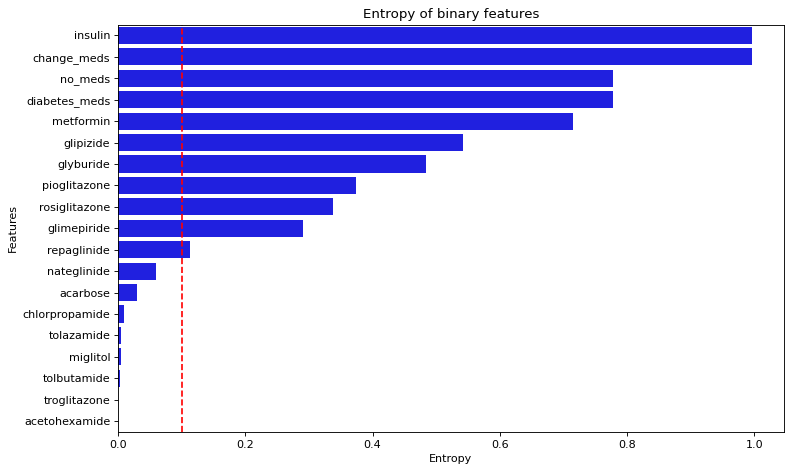

In [122]:
# Lets check the disparity between the binary features (using entropy as a measure)
binary_features_ = data[binary_features]
binary_features_ = binary_features_.apply(lambda x: x.value_counts(normalize=True), axis=0)
binary_features_ = binary_features_.T
binary_features_['entropy'] = binary_features_.apply(lambda x: -np.sum(x*np.log2(x)), axis=1)
binary_features_.sort_values(by='entropy', inplace=True, ascending=False)

plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=binary_features_['entropy'], y=binary_features_.index, color='b')
plt.axvline(x=0.1, color='r', linestyle='--')
plt.title('Entropy of binary features')
plt.xlabel('Entropy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Lets remove the features that have too low entropy to avoid overfitting

In [123]:
to_remove = list(set(binary_features_[binary_features_['entropy'] < 0.1].index.tolist()))
data.drop(to_remove, axis=1, inplace=True, errors='ignore')
binary_features_.drop(to_remove, axis=0, inplace=True)

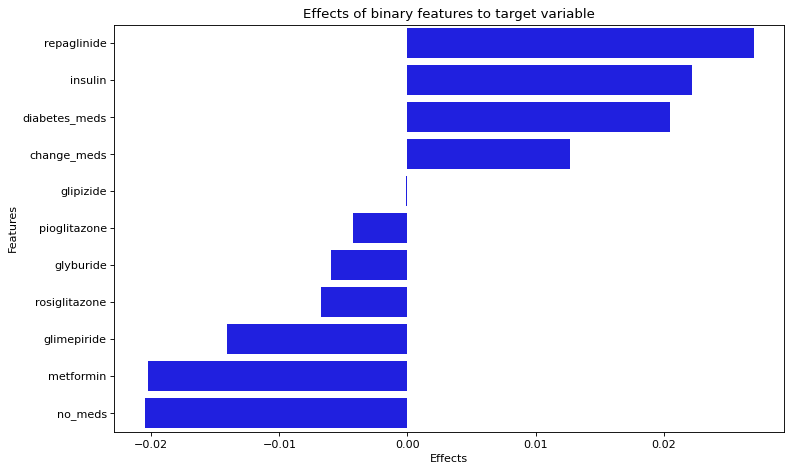

In [124]:
effects = {}
for feature in set(binary_features_.index.tolist()):
    temp = data.groupby(feature)['readmitted_binary'].mean()
    effects[feature] = temp[1] - temp[0]

effects = pd.Series(effects).sort_values(ascending=False)

# Plot the effects with a barplot
plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=effects.values, y=effects.index, color='b')
plt.title('Effects of binary features to target variable')
plt.xlabel('Effects')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [125]:
# Lets remove glizipide because it doesnt affect the target variable
data.drop('glipizide', axis=1, inplace=True)

In [126]:
#binary_features = list(set(binary_features_.index.to_list()))

AttributeError: 'builtin_function_or_method' object has no attribute 'to_list'

### __IV. Taking care of missing data__
Lets check for which values are missing (in percentage of the total dataframe size)

In [127]:
# Making a copy of the data
data_III = data.copy()

In [128]:
def get_missing_per(data):
    isna = (100 * data.isna().sum().sort_values(ascending=False) / len(data))
    isna = isna[isna != 0]

    missing_counts = 100 *data.apply(lambda x: x.value_counts().get('?', 0)).sort_values(ascending=False) / len(data)
    missing_counts = missing_counts[missing_counts != 0]

    # Remove the columns readmitted_binary and readmitted_multiclass, as these are the target variables
    isna = isna.drop(['readmitted_binary', 'readmitted_multiclass'])
    isna = isna.drop(isna.index[isna.index.str.contains('description')])

    return pd.concat([isna, missing_counts], axis=0).sort_values(ascending=False)

get_missing_per(data)

weight                 96.858479
glucose_test_result    94.746772
a1c_test_result        83.277322
medical_specialty      49.082208
payer_code             39.557416
race                    7.134996
age                     4.999705
disposition             3.626948
diag_3                  1.398306
diag_2                  0.351787
diag_1                  0.020636
dtype: float64

#### __0. Taking care of variables with high % of missing values__
We have many variables with a missing value count upwards of 30%, which should be removed. Lets check how they are, before removing them.

##### 1. *Weight*

In [130]:
data.groupby('weight', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
weight,,
NaN,0.111697,68990
87.5,0.109325,933
62.5,0.111635,636
112.5,0.111359,449
137.5,0.052083,96
37.5,0.104478,67
12.5,0.171429,35
162.5,0.095238,21
187.5,0.142857,7


Although there seems to be some variance in the weight, with respect to the target variable, the missing values are too many to be imputed. We will remove this variable, as it might introduce bias in the model.

##### 2. *Glucose test results*

In [131]:
print(data.groupby('glucose_test_result',dropna=False)['readmitted_binary'].mean().sort_values(ascending=False))
print(data.groupby('a1c_test_result', dropna=False)['readmitted_binary'].mean().sort_values(ascending=False))

glucose_test_result
>300    0.142684
>200    0.130806
Norm    0.121816
NaN     0.110647
Name: readmitted_binary, dtype: float64
a1c_test_result
NaN     0.114228
>7      0.101551
Norm    0.099914
>8      0.096231
Name: readmitted_binary, dtype: float64


These two variables are very important to diagnose diabetes, and we can assume that if the test is Nan, it was not performed (probably because the patient was already known to be diabetic). We will impute the missing values with Not Performed.

We are also going to rename the columns to a1c_test_result and glucose_test_result, for better readability, and according to the following article:
<br> '*[A] diagnosis of diabetes can be made when the A1C exceeds 6.5% or when a random glycose level in a patient with classic symptoms exceeds 200 mg/dL.*' (https://www.ncbi.nlm.nih.gov/books/NBK551501/), meaning:
1. We can encode the a1c_test_result as 0 for 'Norma' and 1 for 'Abnormal', since the a1c values range from Norm, >7, >8. 
2. We will also use the glycose reading, with a threshold of >300mg/dL to encode it as 1, and 0 otherwise.
3. We can then join both dataframes, creating a new column name diabetes

In [132]:
glucose_map = {'Norm': 'Normal', '>200': 'Probably diabetic', '>300': 'Diabetic'}
a1c_map = {'Norm': 'Normal', '>7': 'Diabetic', '>8': 'Diabetic'}
data['glucose_test_result'] = data['glucose_test_result'].map(glucose_map).fillna('Not tested')
data['a1c_test_result'] = data['a1c_test_result'].map(a1c_map).fillna('Not tested')
print(data['glucose_test_result'].value_counts(), '\n')
print(data['a1c_test_result'].value_counts())

glucose_test_result
Not tested           96420
Normal                2597
Probably diabetic     1485
Diabetic              1264
Name: count, dtype: int64 

a1c_test_result
Not tested    84748
Diabetic      12028
Normal         4990
Name: count, dtype: int64


##### 3. *Medical specialty*

In [133]:
data.groupby('medical_specialty', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False).head(10)

,mean,count
medical_specialty,,
NaN,0.115858,34922
18.0,0.111543,10292
8.0,0.113179,5319
11.0,0.117117,5217
3.0,0.079386,3716
62.0,0.114739,2144
19.0,0.156690,1136
27.0,0.100629,954
28.0,0.079585,867


In [134]:
data[['medical_specialty','diag_1_description']].value_counts(dropna=False).head(10)

medical_specialty  diag_1_description                                                                                          
NaN                Diabetes mellitus without mention of complication - type II or unspecified type - not stated as uncontrolled    4179
                   Congestive heart failure - unspecified                                                                          3552
                   Coronary atherosclerosis of unspecified type of vessel - native or graft                                        2821
                   Acute myocardial infarction of anterolateral wall - episode of care unspecified                                 1998
                   Respiratory abnormality - unspecified                                                                           1876
3.0                Coronary atherosclerosis of unspecified type of vessel - native or graft                                        1839
NaN                Pneumonia - organism unspecified     

Medical speciality is a tricky one. We have a lot of missing values, but it can explain some of the variance in the target variable. We could try to input the missing values with the help of the primary_diagnosis variable, but then we would just have the same data twice. We will remove this variable.

##### 4. *Insurance provider code*

In [135]:
data.groupby('payer_code',dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
payer_code,,
13.0,0.133333,45
9.0,0.129630,54
8.0,0.125201,2484
7.0,0.118900,22683
10.0,0.115226,729
NaN,0.115209,28201
4.0,0.108466,378
14.0,0.100537,3541
6.0,0.097939,4319


We won't remove this variable, because if there is no code, probably the person doesnt have an insurance provider. Instead we are going to input 'no insurance' to the missing and 'Other' to very low count values, so we can use it later on.

In [136]:
data['payer_code'].fillna('No Insurance', inplace=True)

# For counts bellow 1% we will replace with 'Other'
providor_proportion = data['payer_code'].value_counts(normalize=True)
change = providor_proportion[providor_proportion < 0.01].index
data['payer_code'] = data['payer_code'].replace(change, 'Other')

##### 5. Removing variables mentioned above

In [137]:
weight = data['weight']
medical_specialty = data['medical_specialty']
data = data.drop(['weight', 'medical_specialty'], axis=1, errors='ignore')
categorical_features = list(set(categorical_features) - set(['medical_specialty']))

#### __1. Managing the variable race__

In [138]:
get_missing_per(data)

race           7.134996
age            4.999705
disposition    3.626948
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64

1.1. Using first the patient id to input the missing values, as people usually can't change race

In [139]:
ids_missing = data[data['race'].isna()]['patient_id'].unique()
data_race = data[data['race'].notna()]
interscet = data_race[data_race['patient_id'].isin(ids_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(interscet['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_missing))

Unique patient_ids:  2282
Total patient_ids missing:  6824


In [140]:
missingRace = data[data['race'].isna()]
missingRace = missingRace[missingRace['patient_id'].isin(interscet['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_race_mapping = data_race.groupby('patient_id')['race'].first()
mapper = missingRace.apply(lambda row: patient_race_mapping[row['patient_id']] if pd.isna(row['race']) else row['race'], axis=1)

# Now lets fill the missing values
data.loc[mapper.index, 'race'] = mapper

1.2. If the race was not registered, then it probably means the visit was short. Lets keep the nans as Not Registered, as this could prove valuable latter on 

In [141]:
# Lets see how race is distributed
data.groupby('race', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
race,,
Caucasian,0.115739,51979
AfricanAmerican,0.112928,13026
NaN,0.053998,3389
Hispanic,0.106429,1400
Other,0.087771,1014
Asian,0.098131,428


Race doesn't seem to be correlated to anything, so using a KNN algorithm doesn't make a lot of sense. Lets just use the most comun value to fill in the missing values. Although we will be introducing a bias, as the mean of the NaNs values for the target variable is different from the mean of class 2 (caucasian)

In [142]:
data['race'].fillna('Not Registered', inplace=True)

In [143]:
data.groupby('race', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

,mean,count
race,,
Caucasian,0.115739,51979
AfricanAmerican,0.112928,13026
Not Registered,0.053998,3389
Hispanic,0.106429,1400
Other,0.087771,1014
Asian,0.098131,428


#### __2. Handling the variable age__

In [144]:
get_missing_per(data)

age            4.999705
disposition    3.626948
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64

2.1. Lets use patient id to infer the age, as we previously did for race

In [145]:
ids_missing = data[data['age'].isna()]['patient_id'].unique()
data_age = data[data['age'].notna()]
interscet = data_age[data_age['patient_id'].isin(ids_missing)]

# From those, there are repeated patient_ids, so lets check how many unique patient_ids there are
print('Unique patient_ids: ', len(interscet['patient_id'].unique()))
print('Total patient_ids missing: ', len(ids_missing))

Unique patient_ids:  2214
Total patient_ids missing:  4938


In [146]:
missingAge = data[data['age'].isna()]
missingAge = missingAge[missingAge['patient_id'].isin(interscet['patient_id'].unique())]

# Let's now fill the ids_missing with the first patient id value that is not missing
patient_age_mapping = data_age.groupby('patient_id')['age'].first()
mapper = missingAge.apply(lambda row: patient_age_mapping[row['patient_id']] if pd.isna(row['age']) else row['age'], axis=1)

# Now lets fill the missing values
data.loc[mapper.index, 'age'] = mapper

2.2. If the age was not registered, then it probably means the visit was short. Lets keep the nans as Not Registered, as this could prove valuable latter on 

In [147]:
data.groupby('age', dropna=False)['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=True)

,mean,count
age,,
5.0,0.009524,105
NaN,0.041082,1923
15.0,0.062370,481
55.0,0.101400,11716
45.0,0.106273,6568
35.0,0.110983,2595
65.0,0.111133,15234
95.0,0.117188,1920
75.0,0.119445,17799


We will fill the missing values with 10, because it is between the mean of 5 and 15. Since we will then change the variable to a categorical one, it is okay to do this, as we just want to keep the order of the categories.

In [148]:
data['age'].fillna('10', inplace=True)

#### __3. Filling in the variable disposition__

In [149]:
get_missing_per(data)

disposition    3.626948
diag_3         1.398306
diag_2         0.351787
diag_1         0.020636
dtype: float64

In [150]:
data.groupby('disposition', dropna=False)['readmitted_binary'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False).head(15)

,mean,std,count
disposition,,,
0.0,0.538462,0.518875,13
24.0,0.500000,0.707107,2
14.0,0.397959,0.491994,98
12.0,0.386364,0.492545,44
7.0,0.278536,0.448439,1393
9.0,0.209246,0.407018,822
8.0,0.165323,0.371596,1488
6.0,0.156250,0.368902,32
21.0,0.147268,0.354795,421


Lets fill the missing values with the most common value with the nearest mean target variable

In [151]:
data['disposition'].fillna('Discharged/transferred to home with home health service', inplace=True)

#### __4. Addressing the diagnosis variables__

In [152]:
get_missing_per(data)

diag_3    1.398306
diag_2    0.351787
diag_1    0.020636
dtype: float64

Nan values in the diagnosis could just mean no diagnosis, so we will fill them with 'No Diagnosis'

In [153]:
data['diag_1'] = data['diag_1'].fillna('No Diagnosis')
data['diag_2'] = data['diag_2'].fillna('No Diagnosis')
data['diag_3'] = data['diag_3'].fillna('No Diagnosis')

### __V. Handling Outliers and simplifying variables__
- Numerical features
- Categorical
- Binary

In [218]:
# Lets save a backup of the data
data_IV = data.copy()

In [219]:
# Lets change the name of the columns so we always know what kind they are 
data.columns = ['patient_id', 'c_race', 'c_age', 'c_payer_code', 'num_outvisits', 'num_emvisits', 
        'num_invisits', 'c_admission_type', 'c_disposition', 'c_admission_source', 'num_length_stay',
        'num_tests', 'num_non_lab_proc', 'num_meds', 'c_diag_1', 'c_diag_2', 'c_diag_3', 'num_diag',
        'c_glucose_test', 'c_a1c_test', 'b_change_meds', 'b_diabetes_meds', 'readmitted_binary', 'readmitted_multiclass', 'diag_1_desc', 'diag_2_desc', 
        'diag_3_desc', 'b_glimepiride', 'b_glyburide', 'b_insulin', 'b_pioglitazone', 'b_repaglinide', 'b_rosiglitazone', 'b_metformin', 'b_no_meds']

numerical_features = [col for col in data.columns if col.startswith('num')]
categorical_features = [col for col in data.columns if col.startswith('c_') and col]
binary_features = [col for col in data.columns if col.startswith('b_') and col]

##### __1. Numerical features__

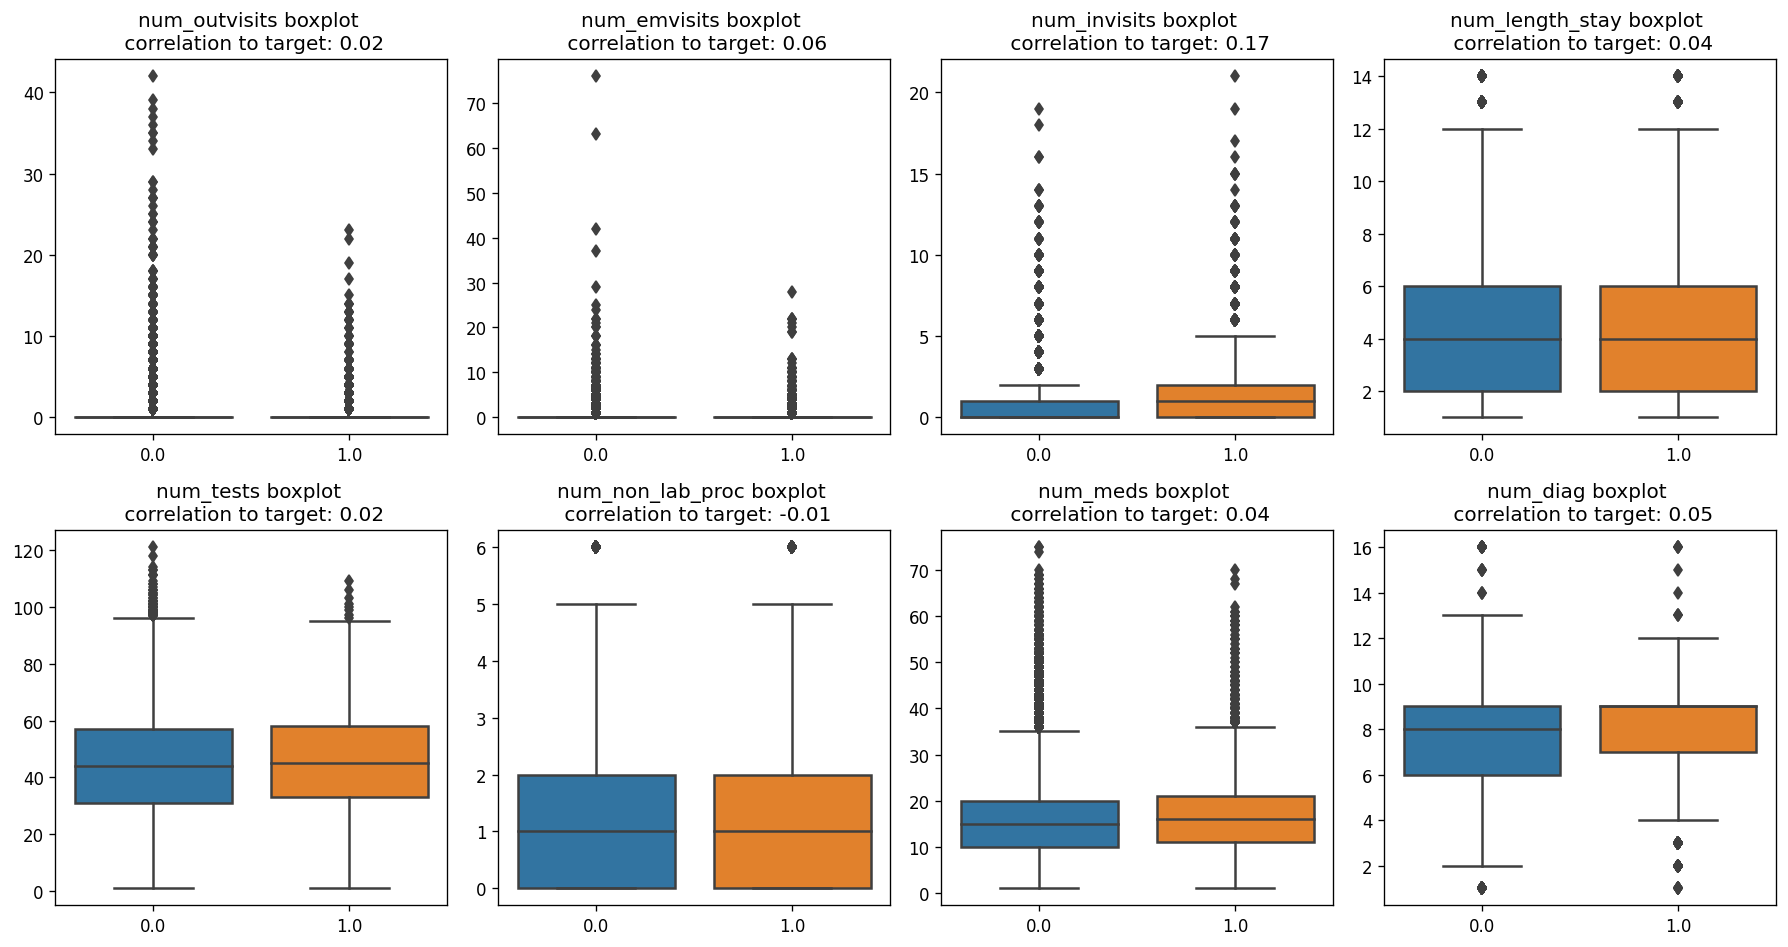

In [220]:
# Lets plot the boxplots for the numerical features
cols_ = 4
rows_ = int(round(len(numerical_features) / cols_))

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = data[feature].corr(data['readmitted_binary'])
    sns.boxplot(x='readmitted_binary', y=feature, data=data, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)}')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

plt.tight_layout()
plt.show()

There are many outliers in emvisits, outvisits, invisits. The problem with these variables is that most of them are 0, so there are very few values that are not 0, and they are very far from the mean.

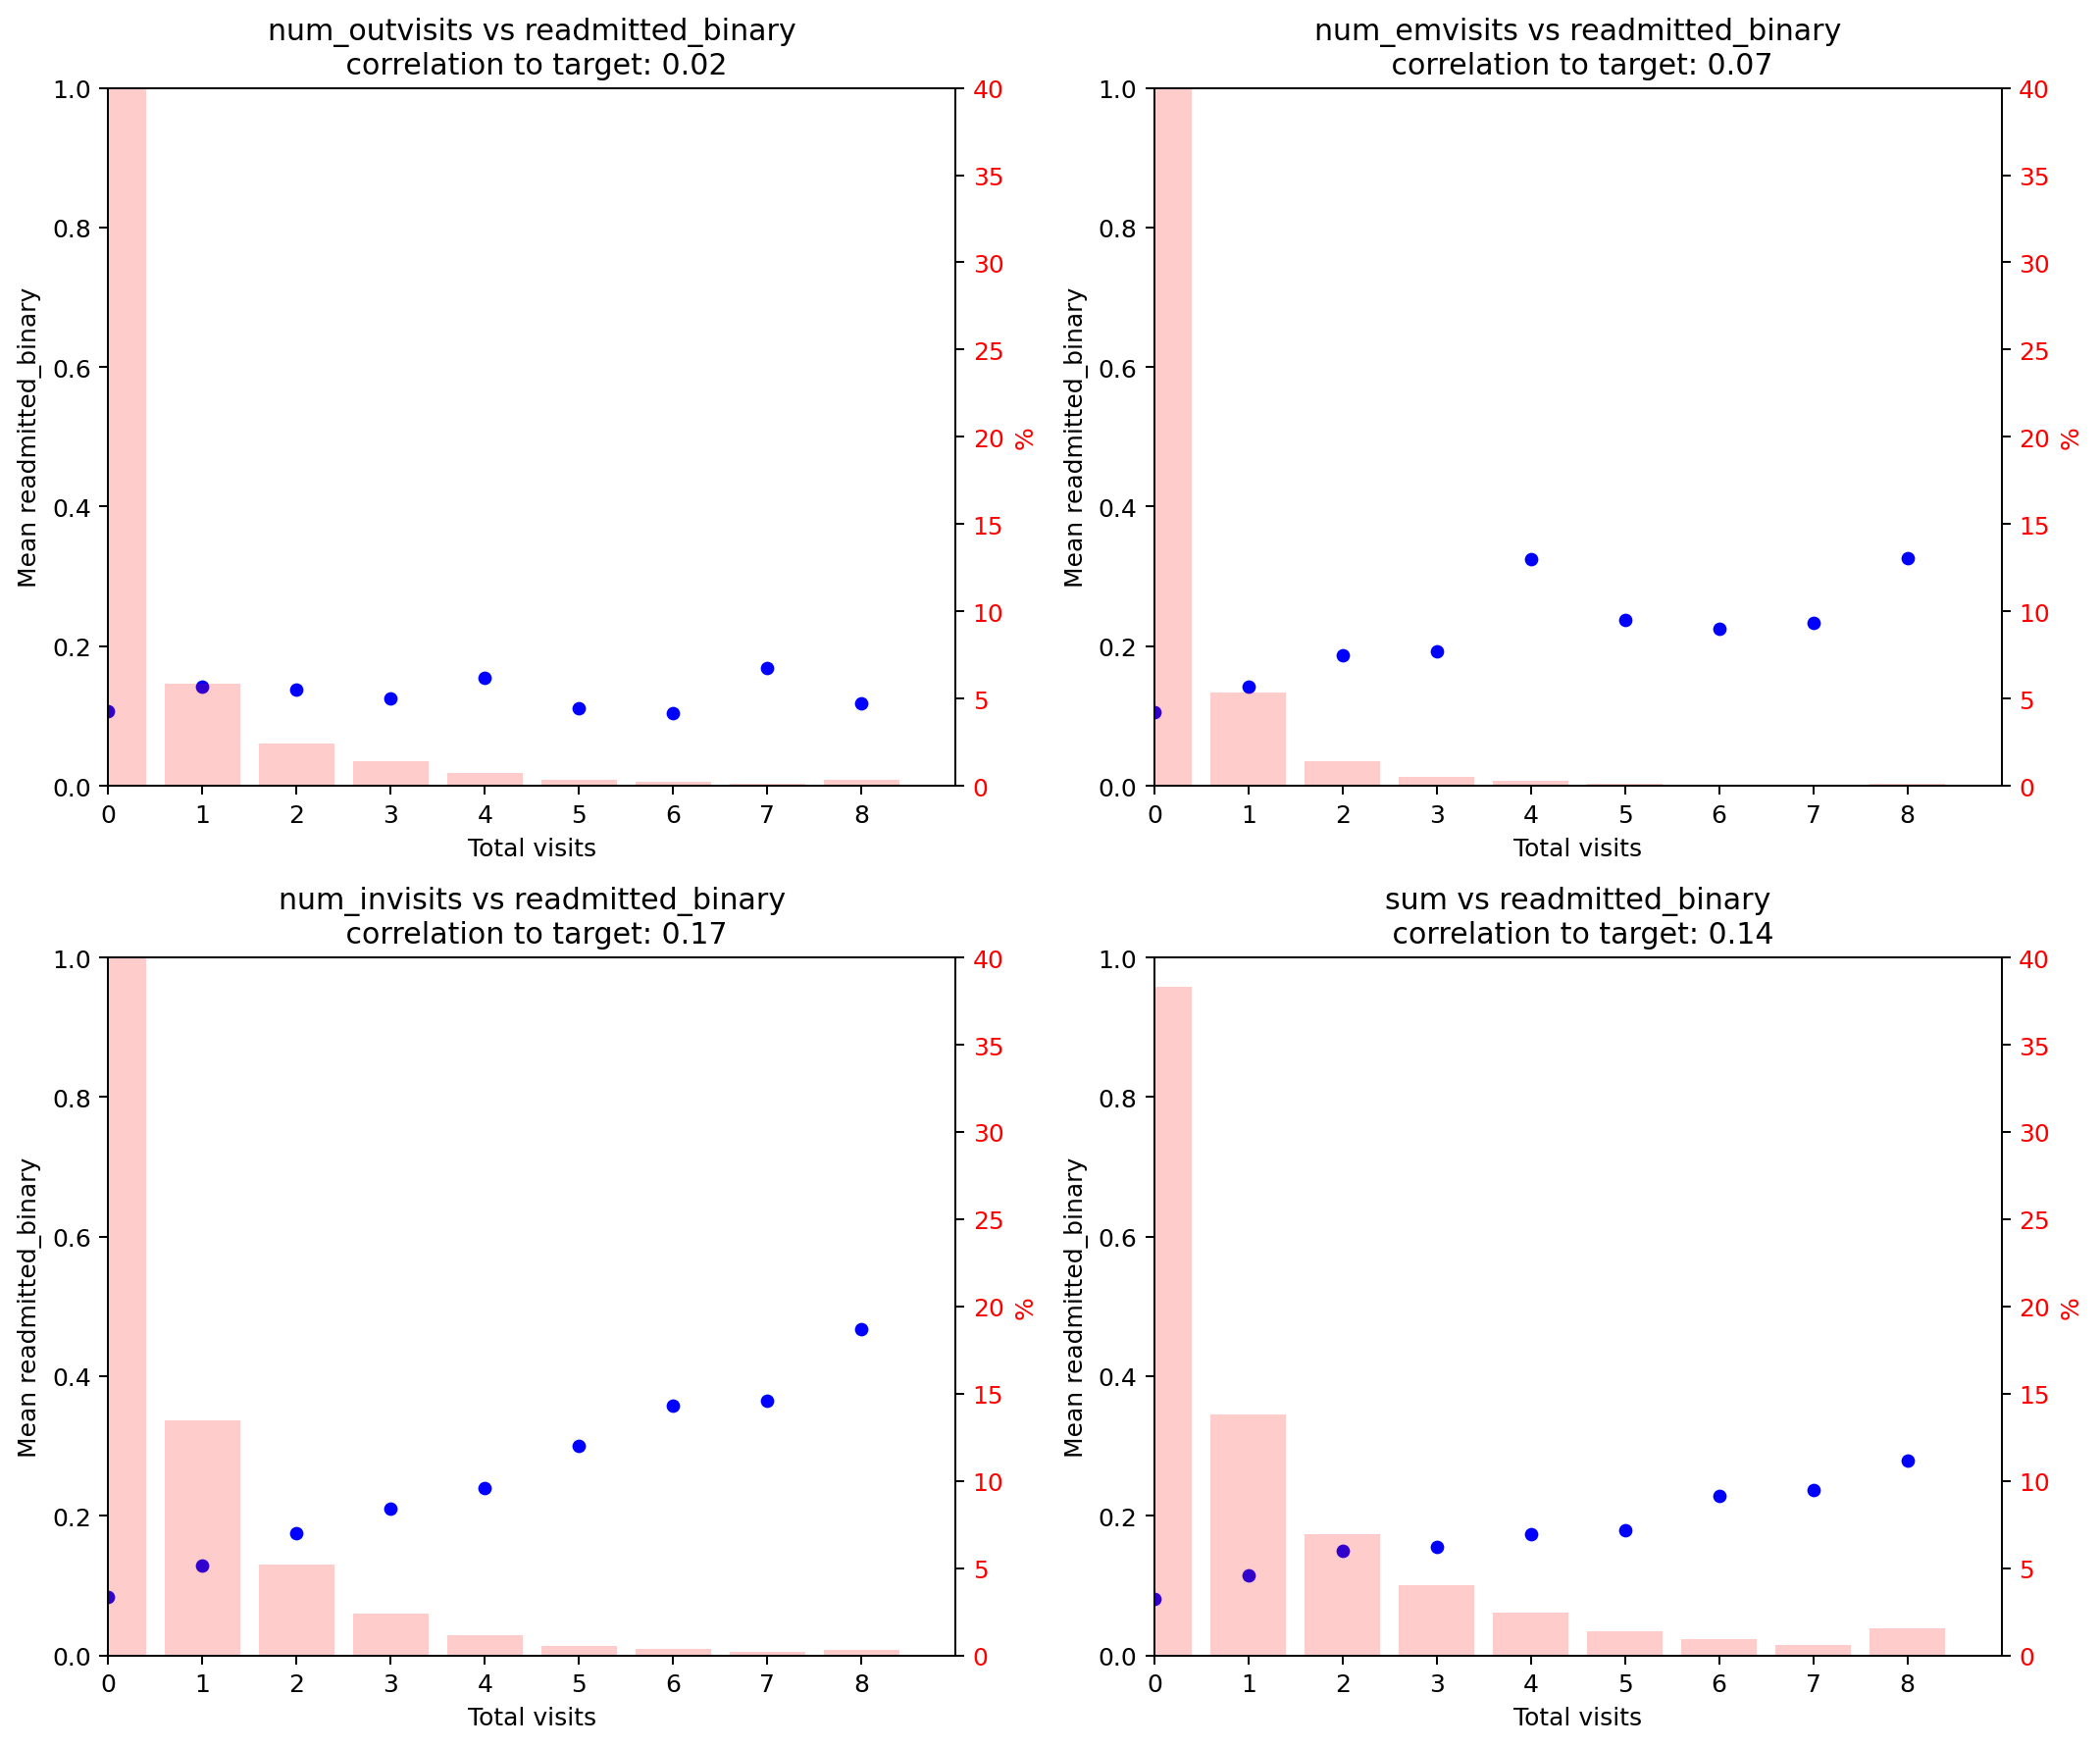

In [223]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi=180)
alpha = 8

for i, feature in enumerate(['num_outvisits', 'num_emvisits', 'num_invisits', 'sum']):
    modified_data = data.copy()
    if feature != 'sum':
        modified_data['new_feature'] = modified_data[feature] 
    else:
        modified_data['new_feature'] = modified_data['num_outvisits'] + modified_data['num_emvisits'] + modified_data['num_invisits']
    modified_data.loc[modified_data['new_feature'] > alpha, 'new_feature'] = alpha
    to_plot = modified_data.groupby('new_feature')['readmitted_binary'].mean()
    correlation = modified_data['new_feature'].corr(modified_data['readmitted_binary'])

    sns.scatterplot(x=to_plot.index, y=to_plot.values, color='b', ax=ax[i//2, i%2])
    # Add on another axis how many values are in each bin
    ax2 = ax[i//2, i%2].twinx()
    ax2.bar(to_plot.index, 100*modified_data.groupby('new_feature')['readmitted_binary'].count()/len(modified_data), alpha=0.2, color='r')
    ax2.grid(False)
    ax2.set_ylabel('%', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, 40)

    ax[i//2, i%2].set_title(f'{feature} vs readmitted_binary\n correlation to target: {round(correlation, 2)}')
    ax[i//2, i%2].set_xlabel('Total visits')
    ax[i//2, i%2].set_ylabel('Mean readmitted_binary')
    ax[i//2, i%2].set_xticks(range(0, alpha+1))
    ax[i//2, i%2].set_xticklabels(range(0, alpha+1))
    ax[i//2, i%2].set_xlim(0, alpha+1)
    ax[i//2, i%2].set_ylim(0, 1)


plt.tight_layout()
plt.show()

Lets keep the sum of these variables and the invisits, and drop the rest.

In [224]:
data['num_visits'] = data['num_outvisits'] + data['num_emvisits'] + data['num_invisits']

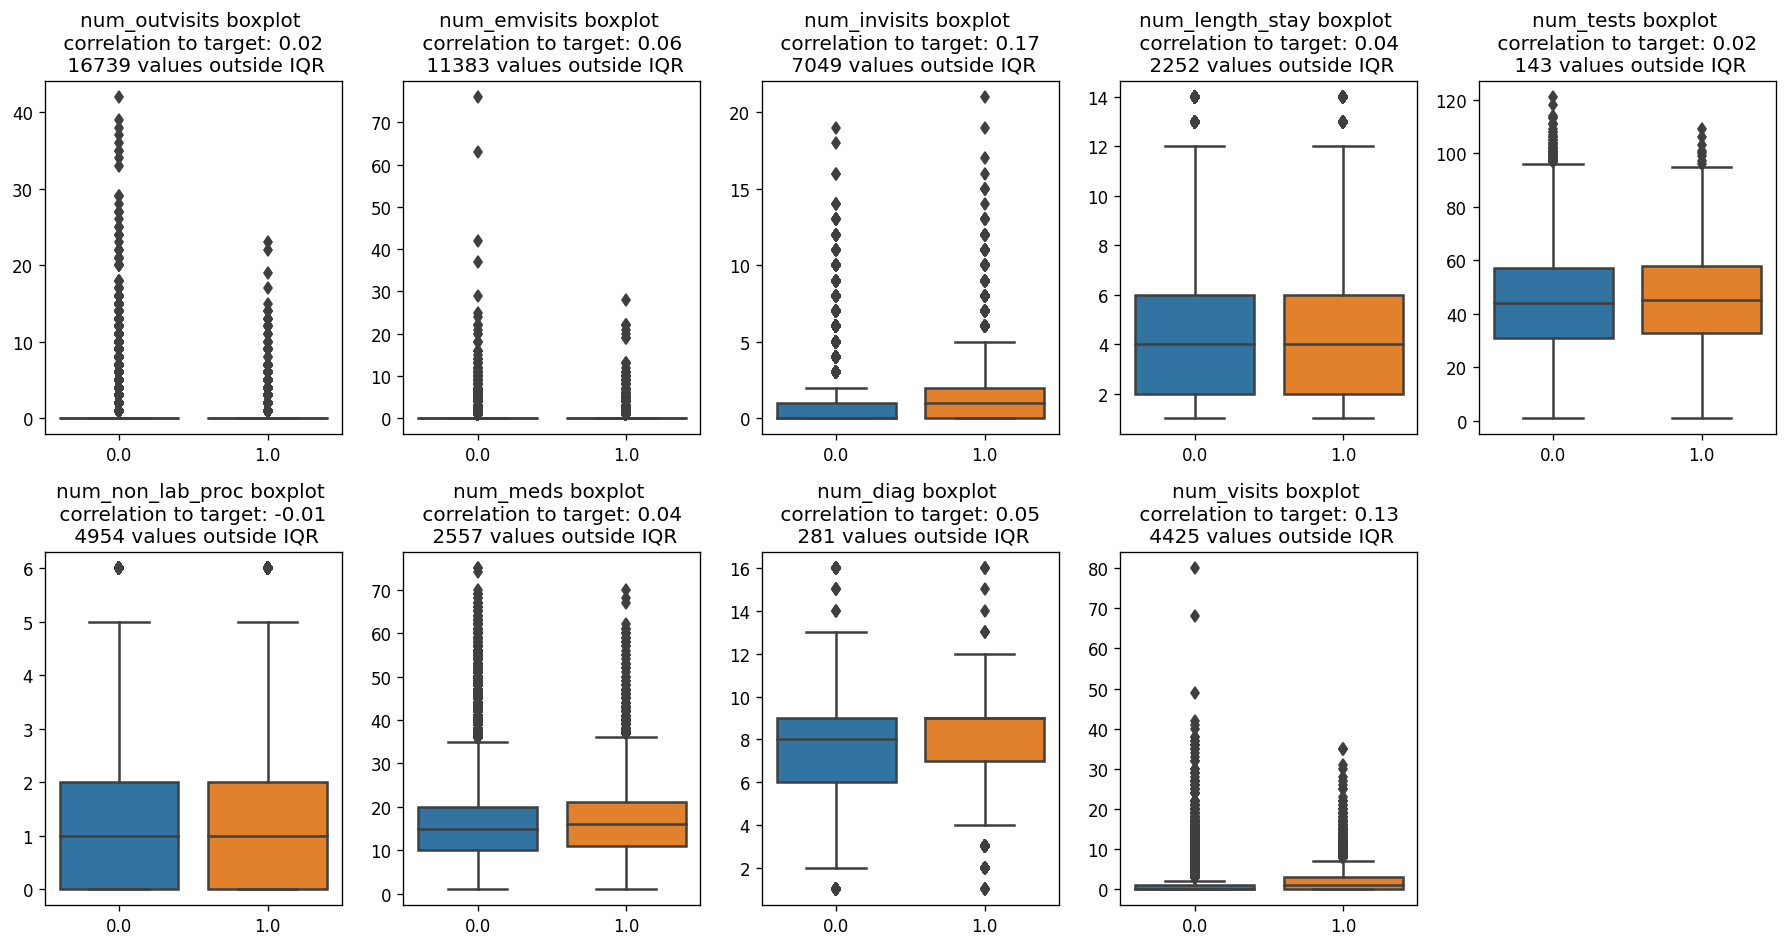

In [225]:
# Lets plot the boxplots for the numerical features
cols_ = 5
rows_ = int(round(len(numerical_features) / cols_))

numerical_features = [col for col in data.columns if col.startswith('num')]

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = data[feature].corr(data['readmitted_binary'])
    outside_iqr_count = len(data[(data[feature] > data[feature].quantile(0.75) + 1.5*(data[feature].quantile(0.75) - data[feature].quantile(0.25))) | (data[feature] < data[feature].quantile(0.25) - 1.5*(data[feature].quantile(0.75) - data[feature].quantile(0.25)))])
    sns.boxplot(x='readmitted_binary', y=feature, data=data, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)} \n {outside_iqr_count} values outside IQR')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

# Remove the last axis
axes[rows_-1, cols_-1].axis('off')
plt.tight_layout()
plt.show()

__invisits and sum_visits:__ for values above alpha, we will replace them with alpha, as they are very far from the mean, and there are very few of them.

In [226]:
alpha = 4
pure_invisits = data['num_invisits'].copy()
pure_emvisits = data['num_emvisits'].copy()
pure_outvisits = data['num_outvisits'].copy()
pure_visits = data['num_visits'].copy()

data.loc[data['num_invisits'] > alpha, 'num_invisits'] = alpha
data.loc[data['num_outvisits'] > alpha, 'num_outvisits'] = alpha
data.loc[data['num_emvisits'] > alpha, 'num_emvisits'] = alpha
data.loc[data['num_visits'] > alpha, 'num_visits'] = alpha

__num_meds:__ lets do the same for num_meds

<Axes: title={'center': 'Average readmission rate for number of medications'}, xlabel='num_meds'>

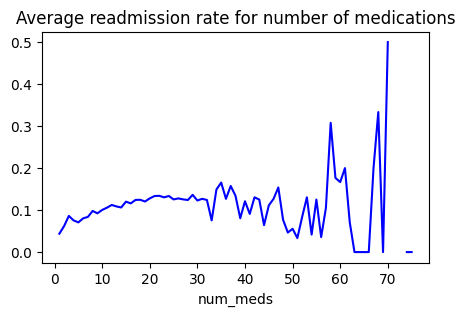

In [227]:
data.groupby('num_meds')['readmitted_binary'].mean().plot(title='Average readmission rate for number of medications', figsize=(5,3), color='b')

there seems to be a nonlinear relationship between num_meds and the target variable, so lets create a new variable num_meds_squared. Also. lets crop num_meds from 55 onwards

In [228]:
beta = 5

pure_num_meds = data['num_meds'].copy()
pure_num_meds_sq = data['num_meds'].copy() ** 2
data.loc[data['num_meds'] > beta, 'num_meds'] = beta
data['num_meds_sq'] = data['num_meds']**2

__num_tests:__

In [229]:
pure_num_tests = data['num_tests'].copy()
data.loc[data['num_tests'] > 100, 'num_tests'] = 100

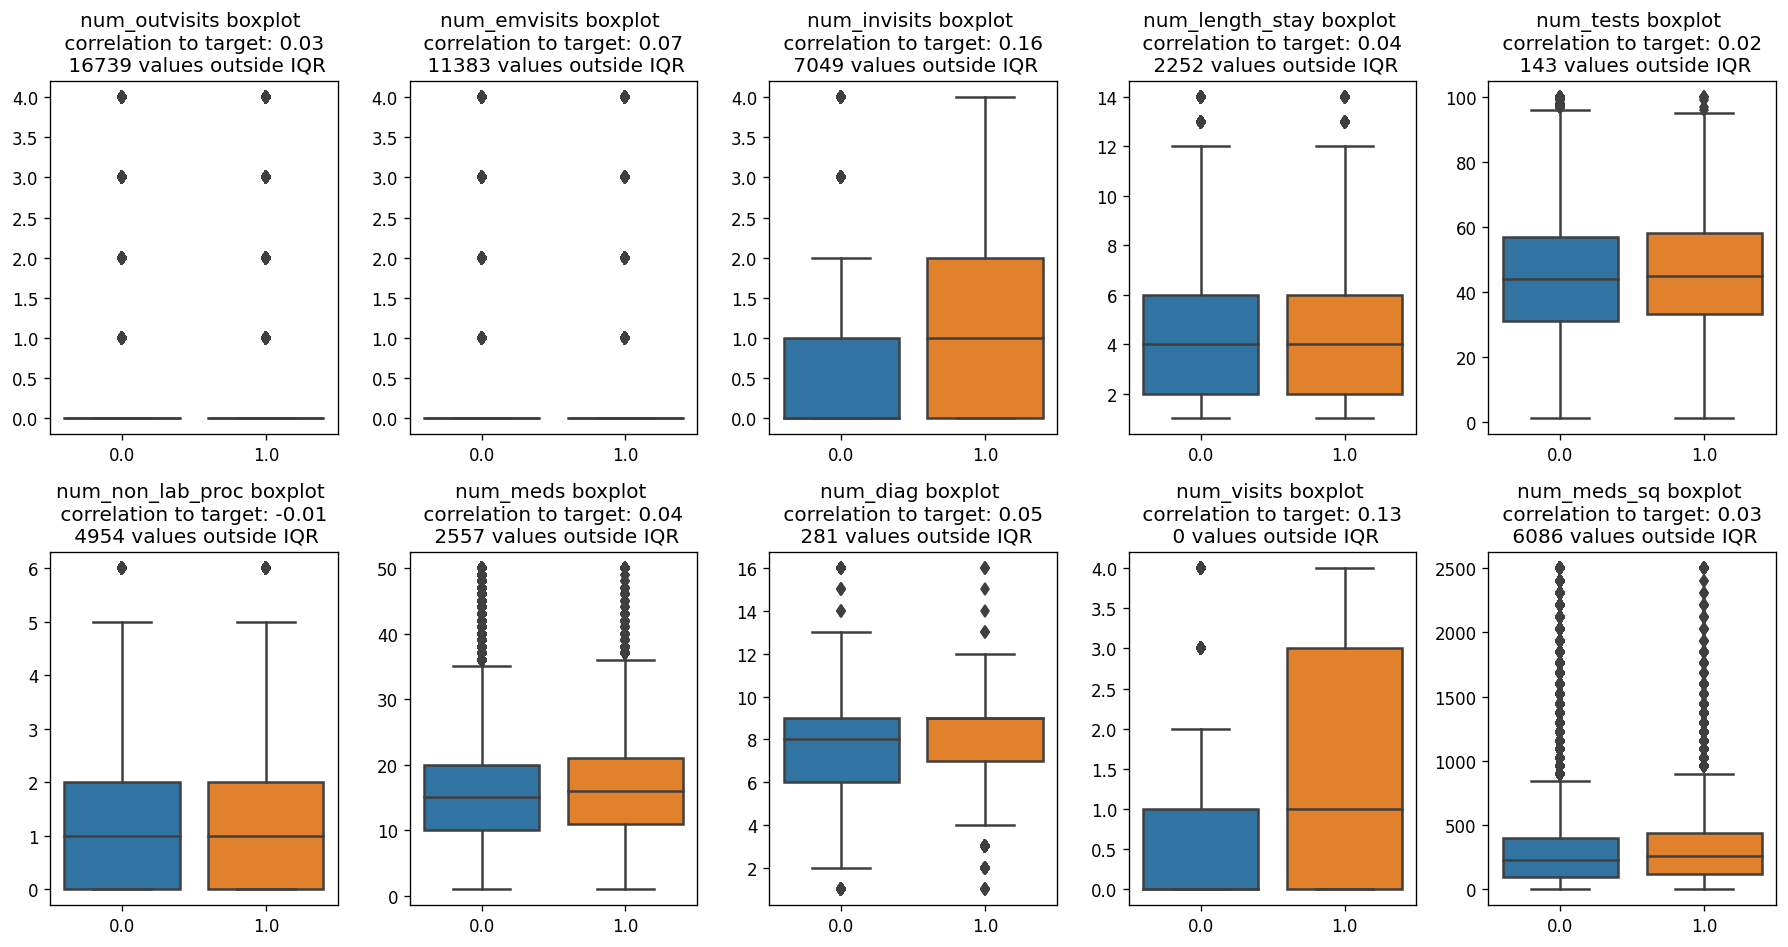

In [230]:
# Lets plot the boxplots for the numerical features
cols_ = 5
rows_ = int(round(len(numerical_features) / cols_))

numerical_features = [col for col in data.columns if col.startswith('num')]

fig, axes = plt.subplots(rows_, cols_, figsize=(15, 8), dpi=120)

for i, feature in enumerate(numerical_features):
    correlation = data[feature].corr(data['readmitted_binary'])
    outside_iqr_count = len(data[(data[feature] > data[feature].quantile(0.75) + 1.5*(data[feature].quantile(0.75) - data[feature].quantile(0.25))) | (data[feature] < data[feature].quantile(0.25) - 1.5*(data[feature].quantile(0.75) - data[feature].quantile(0.25)))])
    sns.boxplot(x='readmitted_binary', y=feature, data=data, ax=axes[i//cols_, i%cols_])
    axes[i//cols_, i%cols_].set_title(f'{feature} boxplot \n correlation to target: {round(correlation, 2)} \n {outside_iqr_count} values outside IQR')
    axes[i//cols_, i%cols_].set_xlabel('')
    axes[i//cols_, i%cols_].set_ylabel('')

# Remove the last axis
plt.tight_layout()
plt.show()

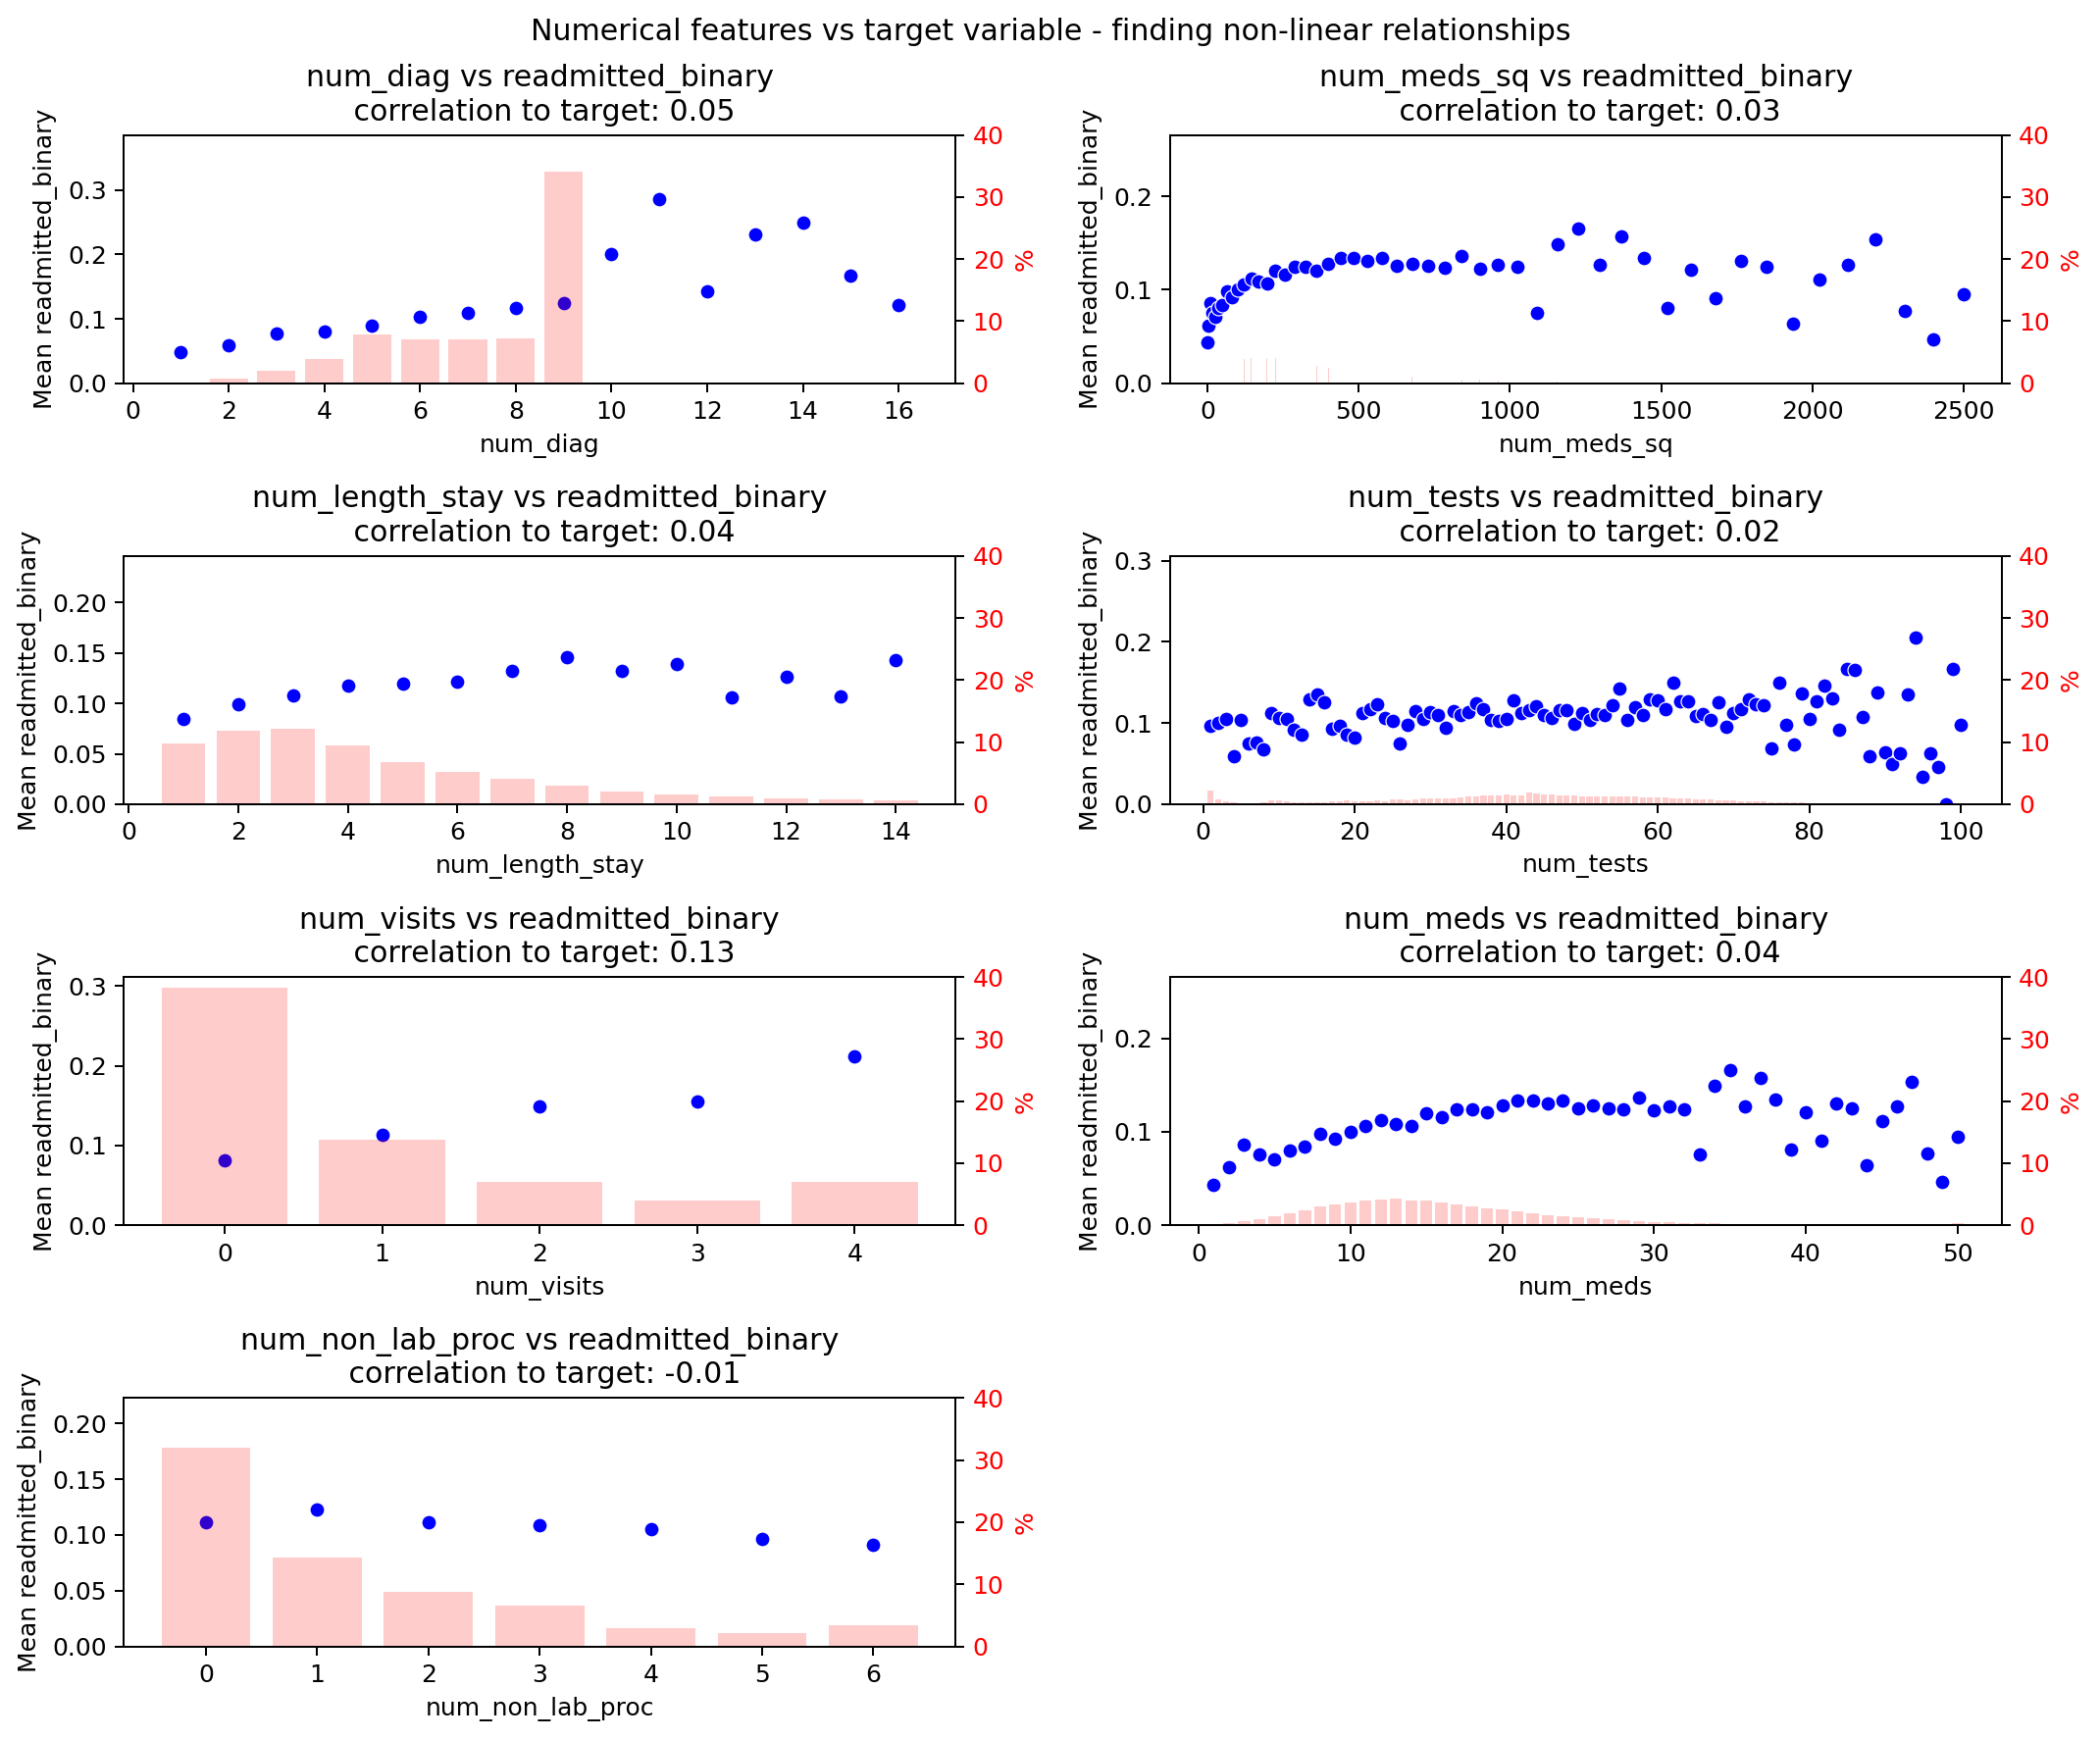

In [231]:
# Lets plot the relationship between the numerical values and the target variable
fig, axes = plt.subplots(4, 2, figsize=(12, 10), dpi=180)

for i, feature in enumerate(set(numerical_features) - set(['sum_visits', 'num_invisits', 'num_outvisits', 'num_emvisits'])):
    # I want the mean of the target variable for each value of the feature
    to_plot = data.groupby(feature)['readmitted_binary'].mean()
    correlation = data[feature].corr(data['readmitted_binary'])
    sns.scatterplot(x=to_plot.index, y=to_plot.values, color='b', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{feature} vs readmitted_binary\n correlation to target: {round(correlation, 2)}')
    axes[i//2, i%2].set_xlabel(feature)
    axes[i//2, i%2].set_ylabel('Mean readmitted_binary')
    axes[i//2, i%2].set_ylim(0, max(to_plot.values)+0.1)
    # Plot the count of each value in the feature
    ax2 = axes[i//2, i%2].twinx()
    ax2.bar(to_plot.index, 100*data.groupby(feature)['readmitted_binary'].count()/len(data), alpha=0.2, color='r')
    ax2.grid(False)
    ax2.set_ylabel('%', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0, 40)

# Delete the last axis
axes[3,1].axis('off')
fig.suptitle('Numerical features vs target variable - finding non-linear relationships')
plt.tight_layout()
plt.show()

##### __2. Categorical features__
- Diagnosis features
- Age feature
- Disposition feature
- Admission Source

In [232]:
data_IV_2 = data.copy()

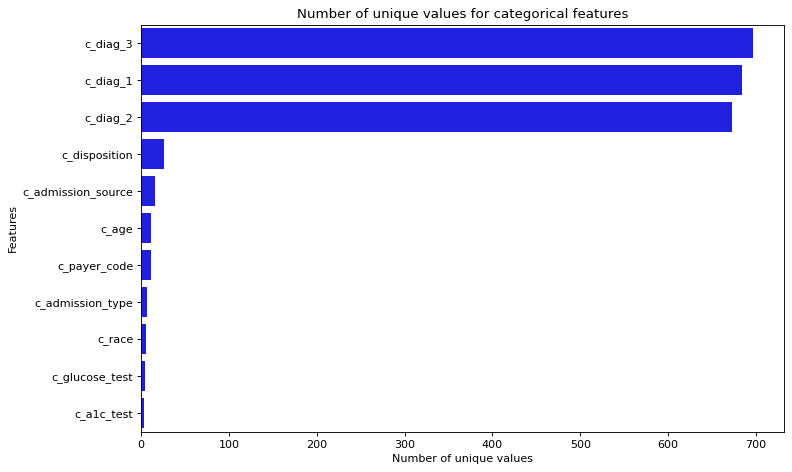

In [233]:
plt.figure(figsize=(10,6), dpi=80)
# Order the number of unique values for categorical features
sns.barplot(x=data[categorical_features].nunique().sort_values(ascending=False).values, y=data[categorical_features].nunique().sort_values(ascending=False).index, color='b')
plt.title('Number of unique values for categorical features')
plt.xlabel('Number of unique values')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

__Diagnosis feaures:__ Lets reduce the dimensionality of the diagnosis codes by grouping them into their respective disease categories. We will wikipedia's page [https://en.wikipedia.org/wiki/List_of_ICD-9_codes] to do so.

In [234]:
# First lets transform the diag features into int type
data['c_diag_1'] = data['c_diag_1'].apply(lambda x: int(x) if x[0] not in ['E', 'V', 'N'] else x[0])
data['c_diag_2'] = data['c_diag_2'].apply(lambda x: int(x) if x[0] not in ['E', 'V', 'N'] else x[0])
data['c_diag_3'] = data['c_diag_3'].apply(lambda x: int(x) if x[0] not in ['E', 'V', 'N'] else x[0])

Before changing the variable completely, lets create a variable is_diabetic that will have a binary value, 1 if the patient has been diagnosed with diabetes and 0 otherwise.

In [235]:
data['b_is_diabetic'] = (data['diag_1_desc'].str.contains('Diabetes') | data['diag_2_desc'].str.contains('Diabetes') | data['diag_3_desc'].str.contains('Diabetes')).apply(lambda x: 1 if x else 0)

In [236]:
# Lets reduce the dimensionality of the diagnosis codes
diag_map = {
    range(1, 140) : 1,
    range(140, 240) : 2,
    range(240, 280) : 3,
    range(280, 290) : 4,
    range(290, 320) : 5,
    range(320, 390) : 6,
    range(390, 460) : 7,
    range(460, 520) : 8,
    range(520, 580) : 9,
    range(580, 630) : 10,
    range(630, 680) : 11,
    range(680, 710) : 12,
    range(710, 740) : 13,
    range(740, 760) : 14,
    range(760, 780) : 15,   
    range(780, 800) : 16,
    range(800, 1000) : 17,
    'E' : 18,
    'V' : 18, 
    'N' : -1
}

for i in range(1, 4):
    data[f'c_diag_{i}'] = data[f'c_diag_{i}'].apply(lambda x: next((v for k, v in diag_map.items() if x in k), x))

In [237]:
diag_description_remap = {
    1 : 'Infectious and Parasitic Diseases',
    2 : 'Neoplasms',
    3 : 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders',
    4 : 'Diseases of the Blood and Blood-forming Organs',
    5 : 'Mental Disorders',
    6 : 'Diseases of the Nervous System and Sense Organs',
    7 : 'Diseases of the Circulatory System',
    8 : 'Diseases of the Respiratory System',
    9 : 'Diseases of the Digestive System',
    10 : 'Diseases of the Genitourinary System',
    11 : 'Complications of Pregnancy, Childbirth, and the Puerperium',
    12 : 'Diseases of the Skin and Subcutaneous Tissue',
    13 : 'Diseases of the Musculoskeletal System and Connective Tissue',
    14 : 'Congenital Anomalies',
    15 : 'Certain Conditions originating in the Perinatal Period',
    16 : 'Symptoms, Signs and Ill-defined Conditions',
    17 : 'Injury and Poisoning',
    18 : 'External Causes of Injury and Supplemental Classification',
    -1 : 'No Diagnosis'
}

for i in range(1, 4):
    data[f'diag_{i}_desc'] = data[f'c_diag_{i}'].map(diag_description_remap)

In [238]:
def merge_small_groups(data, list_featrues, threshold=150):
    # For feature values that have less than threshold values, we will replace with the value with the nearest mean value
    for feature in list_featrues:
        to_replace = data[feature].value_counts()
        to_replace = to_replace[to_replace < threshold].index.to_list()
        if to_replace == []:
            continue
        for value in to_replace:
            # Find the nearest value that has more than threshold values
            means = data.groupby(feature)['readmitted_binary'].mean().sort_values(ascending=False)
            target_mean = means.loc[value]
            means = means[means.index.isin(to_replace) == False]  # exclude values with less than 100 counts
            nearest_value = (means - target_mean).abs().idxmin()  # find the nearest value
            # Replace the value
            data.loc[data[feature] == value, feature] = nearest_value

#merge_small_groups(data, ['diag_1', 'diag_2', 'diag_3'], threshold=150)

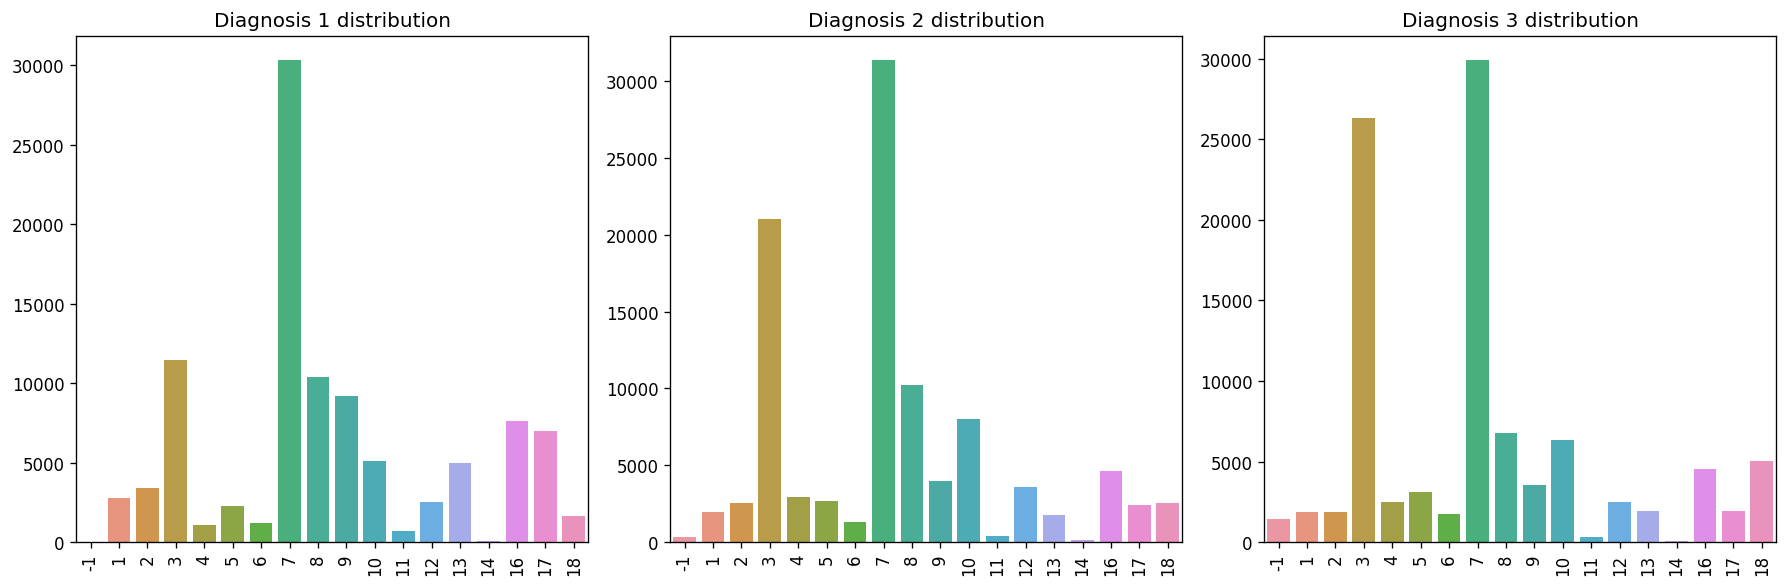

In [239]:
# Lets plot the distribution of the diagnosis codes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=120)

for i in range(1, 4):
    sns.countplot(x=f'c_diag_{i}', data=data, ax=axes[i-1])
    axes[i-1].set_title(f'Diagnosis {i} distribution')
    axes[i-1].set_xlabel('')
    axes[i-1].set_ylabel('')
    axes[i-1].set_xticklabels(axes[i-1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

__Age:__ We dont want age to lose its ordinality, but lets change its encoding to a more intuitive one


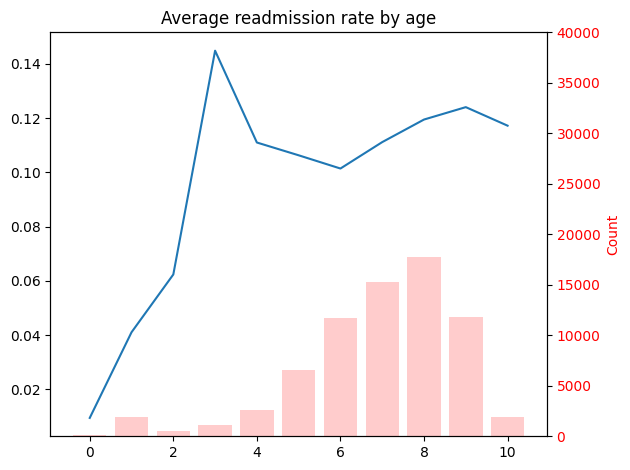

In [240]:
le_num_age = LabelEncoder()
data['num_age'] = data['c_age']
data.drop('c_age', axis=1, inplace=True)

data['num_age'] = data['num_age'].astype(int)
data['num_age'] = le_num_age.fit_transform(data['num_age'])

plt.plot(data.groupby('num_age')['readmitted_binary'].mean())
ax2 = plt.twinx()
ax2.bar(data.groupby('num_age')['readmitted_binary'].mean().index, data.groupby('num_age')['readmitted_binary'].count(), alpha=0.2, color='r')
ax2.grid(False)
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 40000)
plt.title('Average readmission rate by age')
plt.xlabel('age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

There could be non-linear relationships between the target variable and this feature (age), so lets create a new feature that is the square of age

In [241]:
data['num_age_sq'] = data['num_age']**2

__Disposition:__

In [242]:
grouping = data.groupby('c_disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
c_disposition,,
0.0,0.538462,13
24.0,0.500000,2
14.0,0.397959,98
12.0,0.386364,44
7.0,0.278536,1393
9.0,0.209246,822
8.0,0.165323,1488
6.0,0.156250,32
21.0,0.147268,421


In [243]:
# There are many categories that seem irrelevant, so lets group them (expired, hospice, and very low-frequency categories)
data['c_disposition'] = data['c_disposition'].apply(lambda x: 'Expired' if x in grouping.iloc[18:].index.to_list() else x)

In [244]:
grouping = data.groupby('c_disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).head(10)
grouping

,mean,count
c_disposition,,
0.0,0.538462,13
24.0,0.500000,2
14.0,0.397959,98
12.0,0.386364,44
7.0,0.278536,1393
9.0,0.209246,822
8.0,0.165323,1488
6.0,0.156250,32
21.0,0.147268,421


In [245]:
# High mean categories will be grouped together as well 
data['c_disposition'] = data['c_disposition'].apply(lambda x: 'Rehab' if x in grouping.iloc[:5].index.to_list() else x)

In [246]:
grouping = data.groupby('c_disposition')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
c_disposition,,
Rehab,0.291613,1550
9.0,0.209246,822
8.0,0.165323,1488
6.0,0.156250,32
21.0,0.147268,421
3.0,0.146217,9780
Discharged/transferred to home with home health service,0.127799,2590
11.0,0.126374,9005
2.0,0.124343,571


In [247]:
data['c_disposition'] = data['c_disposition'].apply(lambda x: 'Home' if x in ['Discharged to home', 'Not Mapped'] else x)
# Although AMA has nothing to do with home_care, it makes sense to group them together as in both cases the patient can return home its just not advised
data['c_disposition'] = data['c_disposition'].apply(lambda x: 'Home_Care' if x in ['Discharged/transferred to home with home health service', 'Discharged/transferred to ICF', 'Discharged/transferred to home under care of Home IV provider', 'Left AMA'] else x)
data['c_disposition'] = data['c_disposition'].apply(lambda x: 'Transfer short term' if x in ['Discharged/transferred to another short term hospital', 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.'] else x)
data['c_disposition'] = data['c_disposition'].apply(lambda x:  'Hospice' if x in ['Hospice / home', 'Hospice / medical facility'] else x)
# Rename the Discharged/transferred to another type of inpatient care institution to Transfer long term
data['c_disposition'] = data['c_disposition'].apply(lambda x: 'Transfer inpatient' if x in ['Discharged/transferred to another type of inpatient care institution'] else x)

__Admission source:__

In [248]:
grouping = data.groupby('c_admission_source')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
c_admission_source,,
0,0.181818,11
13,0.155039,129
4,0.140187,107
8,0.127731,595
11,0.125000,8
1,0.116620,40319
3,0.106325,4806
12,0.105263,779
5,0.105184,20678


There doesnt seem to be a lot of variance to be explained here, so use the function to group small groups

In [249]:
merge_small_groups(data, ['c_admission_source'], threshold=200)

In [250]:
data.groupby('c_admission_source')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
c_admission_source,,
8,0.134204,842
1,0.116622,40327
3,0.106325,4806
12,0.105263,779
5,0.105184,20678
9,0.097311,1562
15,0.095450,2242


__Admission type:__

In [251]:
grouping = data.groupby('c_admission_type')['readmitted_binary'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
grouping

,mean,count
c_admission_type,,
1,0.114938,37742
6,0.112101,13024
3,0.108312,7026
0,0.103853,13211
4,0.088785,214
2,0.000000,6
5,0.000000,13


In [252]:
merge_small_groups(data, ['c_admission_type'], threshold=150)

__Filtering the dataframe:__

Lets check the results

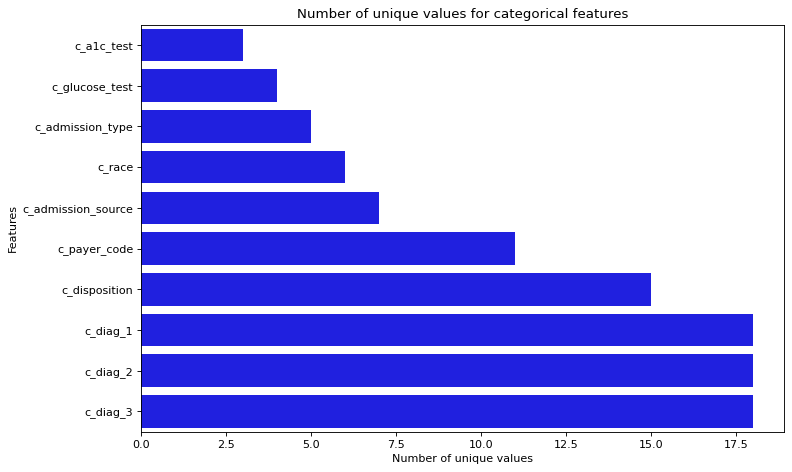

In [253]:
categorical_features = [col for col in data.columns if col.startswith('c_') and col]

plt.figure(figsize=(10,6), dpi=80)
sns.barplot(x=data[categorical_features].nunique().sort_values().values, y=data[categorical_features].nunique().sort_values().index, color='b')
plt.title('Number of unique values for categorical features')
plt.xlabel('Number of unique values')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### __VI. Fine tuning the data + Feature engineering__
- Creating new features
- Chosing which features to select

In [254]:
# Generate and save a ydata profile report
#data_profiling = data.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_description', 'diag_2_description', 'diag_3_description', 'patient_id'], axis=1)
#profile = ProfileReport(data_profiling, title='Pandas Profiling Report', explorative=True)
#profile.to_file("Pandas Profiling Report.html")

1.1. Was the patient ever readmitted?

### __VI. Fitting a model__

In [276]:
def test_data(data, return_score=False, over_sampled=False, scaler=StandardScaler(), model=LogisticRegression(max_iter=10000)):  
    X = data[data['readmitted_binary'].notna()]
    y = X['readmitted_binary']
    X = X.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'patient_id'], axis=1)

    # Age should be considered a categorical variable (ordinal)
    categorical_features = [col for col in X.columns if col.startswith('c_') and col]
    numerical_features = [col for col in X.columns if col.startswith('num') and col]

    # Change the categorical features to strings
    for feature in categorical_features:
        X[feature] = X[feature].astype(str)

    # Initialize the one hot encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit and transform the encoder on the categorical features
    encoded = encoder.fit_transform(X[categorical_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)

    # Concatenate the original DataFrame X with the encoded DataFrame
    X = pd.concat([X, encoded_df], axis=1)

    # Drop the original categorical features as they have been encoded now
    X.drop(categorical_features, axis=1, inplace=True)

    # Scale data
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    # Use kfold cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Under sample the majority class
        sampler = RandomUnderSampler(random_state=42) if not over_sampled else RandomOverSampler(random_state=42)
        X_train, y_train = sampler.fit_resample(X_train, y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))

    print(f'Mean f1 score {round(np.mean(f1_scores),3)} +- {round(np.std(f1_scores),3)}') if not return_score else None
    if return_score:
        return np.mean(f1_scores), np.std(f1_scores)

def test_model(model, X_train, y_train, X_test, y_test, just_score=False, k_fold=True): 
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        return fit, f1_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    return fit

def kfold_model(model, X, y, over=False):
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Initialize the classifier
    model = LogisticRegression(max_iter=10000)
    undersampler = RandomUnderSampler(random_state=42)
    oversampler = RandomOverSampler(random_state=42)

    scores = []
    # Iterate over each fold
    for train_index, test_index in kf.split(X):
        # Get the training and testing data for this fold
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Undersample the training data for this fold
        if over == True:
            X_train, y_train = oversampler.fit_resample(X_train_fold, y_train_fold)
        else:
            X_train, y_train = undersampler.fit_resample(X_train_fold, y_train_fold)
        
        # Train your model on the undersampled training data
        model.fit(X_train, y_train)
        
        # Evaluate your model on the testing data for this fold
        scores.append(f1_score(y_test_fold, model.predict(X_test_fold)))
    
    print(f'Mean f1 score {round(np.mean(scores),3)} +- {round(np.std(scores),3)}')
    return np.mean(scores), np.std(scores)

__alpha for num_visits:__

In [332]:
score_mean_standard, score_std_standard, score_mean_minmax, score_std_minmax, score_mean_robust, score_std_robust, score_mean_minmax_neg, score_std_mixmax_neg = {}, {}, {}, {}, {}, {}, {}, {}

for alpha in range(1,10):
    data_temp = data.copy()
    emvisits = pure_emvisits.copy()
    outvisits = pure_outvisits.copy()
    invisits = pure_invisits.copy()
    visits = pure_visits.copy()

    # Use the alpha value to set the threshold
    emvisits.loc[emvisits > alpha] = alpha
    outvisits.loc[outvisits > alpha] = alpha
    invisits.loc[invisits > alpha] = alpha
    visits.loc[visits > alpha] = alpha

    # Add the new features to the data
    data_temp['num_emvisits'] = emvisits
    data_temp['num_outvisits'] = outvisits
    data_temp['num_invisits'] = invisits
    data_temp['num_visits'] = visits

    # Calculate the f1 score
    score_mean_standard[alpha], score_std_standard[alpha] = test_data(data_temp, return_score=True, scaler=StandardScaler())
    score_mean_minmax[alpha], score_std_minmax[alpha] = test_data(data_temp, return_score=True, scaler=MinMaxScaler())
    score_mean_robust[alpha], score_std_robust[alpha] = test_data(data_temp, return_score=True, scaler=RobustScaler())
    score_mean_minmax_neg[alpha], score_std_mixmax_neg[alpha] = test_data(data_temp, return_score=True, scaler=MinMaxScaler(feature_range=(-1,1)))

results = pd.DataFrame({'StandardScaler': score_mean_standard, 'MinMaxScaler': score_mean_minmax, 'RobustScaler': score_mean_robust, 'MinMaxScaler(-1,1)': score_mean_minmax_neg})
print('Best alpha value: ', max(score_mean_standard, key=score_mean_standard.get))
print('Best mean f1 score: ', score_mean_standard[max(score_mean_standard, key=score_mean_standard.get)])
print('Standard deviation: ', score_std_standard[max(score_mean_standard, key=score_mean_standard.get)])
print('Best scaler: ', results.idxmax(axis=1).value_counts().index[0])

Best alpha value:  4
Best mean f1 score:  0.2752083123828165
Standard deviation:  0.0025169405638630804
Best scaler:  MinMaxScaler


__beta for num_meds:__

In [327]:
# Lets do exactly the same but with the num_meds
score_mean, score_std = {}, {}

for beta in range(1, 100, 2):
    data_temp = data.copy()
    num_meds = pure_num_meds.copy()

    # Use the alpha value to set the threshold
    num_meds.loc[num_meds > beta] = beta
    num_meds_sq = num_meds ** 2

    # Add the new features to the data
    data_temp['num_meds'] = num_meds
    data_temp['num_meds_sq'] = num_meds_sq

    # Calculate the f1 score
    score_mean[beta], score_std[beta] = test_data(data_temp, return_score=True, scaler=MinMaxScaler())

results = pd.DataFrame({'Mean': score_mean, 'Std': score_std})
results['Score'] = results['Mean'] - 0.5*results['Std']
print('Best beta value: ', results['Score'].idxmax())
print('Best mean f1 score: ', score_mean[results['Score'].idxmax()])
print('Standard deviation: ', score_std[results['Score'].idxmax()]) 

Best beta value:  5
Best mean f1 score:  0.2753206420521394
Standard deviation:  0.001346411871181294


In [354]:
# Change num_meds to the best beta value (5)
data.loc[data['num_meds'] > 5, 'num_meds'] = 5

# Since beta is so small, we dont need a squared feature
data.drop('num_meds_sq', axis=1, inplace=True)

##### __Models:__

In [355]:
test_data(data)

Mean f1 score 0.275 +- 0.001


In [356]:
# Define variables for columns to drop, target variable, and features to scale
cols_to_drop = []

# Preprocessing
X = data
y = X['readmitted_binary'].dropna()
X_final_test = X[X['readmitted_binary'].isna()]
X = X[X['readmitted_binary'].notna()]

X = X.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'patient_id'], axis=1)
X_final_test = X_final_test.drop(['readmitted_binary', 'readmitted_multiclass', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'patient_id'], axis=1)
X = X.drop(cols_to_drop, axis=1)
X_final_test = X_final_test.drop(cols_to_drop, axis=1)

# Age should be considered a categorical variable (ordinal)
categorical_features = [col for col in X.columns if col.startswith('c_') and col]
features_to_scale = [col for col in X.columns if col.startswith('num_') and col]

X[categorical_features] = X[categorical_features].astype(str)
X_final_test[categorical_features] = X_final_test[categorical_features].astype(str)

# Initialize the one hot encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the encoder on the categorical features
encoded = encoder.fit_transform(X[categorical_features])
encoded_final_test = encoder.transform(X_final_test[categorical_features])

# Convert the encoded features into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features), index=X.index)
encoded_df_final_test = pd.DataFrame(encoded_final_test, columns=encoder.get_feature_names_out(categorical_features), index=X_final_test.index)

# Concatenate the original DataFrame X with the encoded DataFrame
X = pd.concat([X, encoded_df], axis=1)
X_final_test = pd.concat([X_final_test, encoded_df_final_test], axis=1)

# Drop the original categorical features as they have been encoded now
X.drop(categorical_features, axis=1, inplace=True)
X_final_test.drop(categorical_features, axis=1, inplace=True)

# Scale the numerical features
scaler = MinMaxScaler()
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])
X_final_test[features_to_scale] = scaler.transform(X_final_test[features_to_scale])

In [357]:
# Lets undersample the minority class
#sampler = RandomUnderSampler(random_state=42)
sampler = RandomOverSampler(random_state=42)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.3, random_state=17)

# Fit the sampler to the training data
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [358]:
fit = test_model(LogisticRegression(max_iter=10000), X_train, y_train, X_test, y_test)

Accuracy:  0.6692714426091433
Precision:  0.18625217740854885
Recall:  0.5828092243186582
F1:  0.28229082047116166
Confusion matrix: 
 [[12913  6073]
 [  995  1390]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.68      0.79     18986
         1.0       0.19      0.58      0.28      2385

    accuracy                           0.67     21371
   macro avg       0.56      0.63      0.53     21371
weighted avg       0.85      0.67      0.73     21371



F1 score:  0.1645493042952208


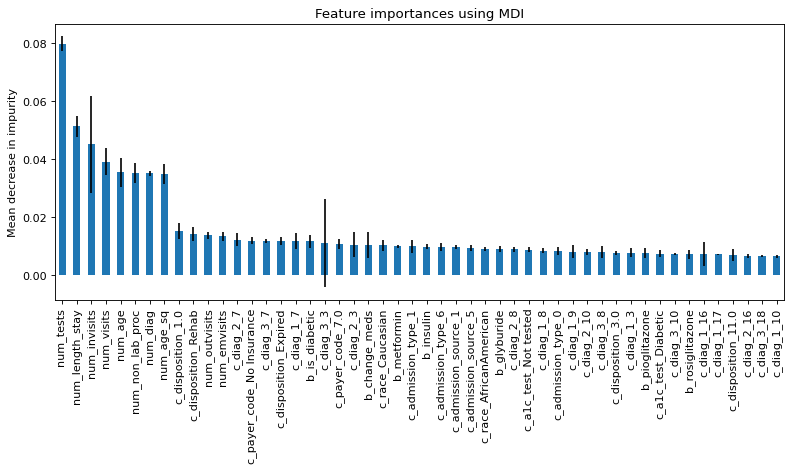

In [365]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(bootstrap=True, criterion='gini', min_samples_leaf=1, min_samples_split=23, n_estimators=278, random_state=42)

rf_classifier.fit(X_train, y_train)

feature_names = [i for i in X_train.columns]
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,6), dpi=80)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.head(50).plot.bar(yerr=std[:50], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Print f1 score
y_pred = rf_classifier.predict(X_test)
print('F1 score: ', f1_score(y_test, y_pred))

In [291]:
# Lets try RFE to select the best features
from sklearn.feature_selection import RFE

rfe = RFE(rf_classifier, n_features_to_select=5, step=1, verbose=True)
rfe.fit(X_train, y_train)

# Print f1 score
y_pred = rfe.predict(X_test)
print('F1 score: ', f1_score(y_test, y_pred))

Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
F

In [292]:
# Get the most important features ranked in a dataframe
important_features = pd.DataFrame({'feature': X_train.columns, 'importance': rfe.ranking_})
important_features.sort_values(by='importance', inplace=True)
important_features

,feature,importance
60,c_disposition_Rehab,1
2,num_invisits,1
27,num_visits,1
56,c_disposition_Expired,1
57,c_disposition_Home,1
...,...,...
16,b_miglitol,124
11,b_chlorpropamide,125
22,b_tolbutamide,126
24,b_acetohexamide,127


In [317]:
X_ = X[important_features.head(25)['feature']]
X_final_test_ = X_final_test[important_features.head(25)['feature']]

model = LogisticRegression(max_iter=10000)
kfold_model(model, X_, y, over=True)

Mean f1 score 0.274 +- 0.008


(0.27428031626879656, 0.008279165325846114)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, f1_score

# Make an F1 scoring function
f1_scorer = make_scorer(f1_score, average='micro')

# The "estimator" is a classifier
estimator = LogisticRegression(max_iter=10000)

# The "step" parameter determines the amount of features to remove at each iteration
selector = RFECV(estimator, step=1, cv=5, scoring=f1_scorer, verbose=True, n_jobs=-1)
selector = selector.fit(X, y)

# The support mask shows which features are selected
X_new = X[:, selector.support_]

In [366]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define a range of hyperparameters to search
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(2, 50),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=200, cv=5, n_jobs=-1, random_state=13, scoring='f1', verbose=1)

# Fit the RandomizedSearchCV object to your training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best hyperparameters:", random_search.best_params_)

# Evaluate the model on the test data
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
print('F1: ', f1_score(y_test, y_pred))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
models = [LogisticRegression(random_state=42, max_iter=1000), MLPClassifier(random_state=42, max_iter=1000), SVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42), KNeighborsClassifier(), GaussianNB()]

for model in models:
    print(f'Fitting {model.__class__.__name__}')
    fit, score = test_model(model, X_train, y_train, X_test, y_test, just_score=True)
    print(f'Score for mode {model.__class__.__name__}: ', score)

Fitting LogisticRegression
Score for mode LogisticRegression:  0.2707769617317356
Fitting MLPClassifier
Score for mode MLPClassifier:  0.23482254697286015
Fitting SVC
Score for mode SVC:  0.24411508282476022
Fitting RandomForestClassifier
Score for mode RandomForestClassifier:  0.2588572966185308
Fitting XGBClassifier
Score for mode XGBClassifier:  0.25180744136836536
Fitting KNeighborsClassifier
Score for mode KNeighborsClassifier:  0.2206896551724138
Fitting GaussianNB
Score for mode GaussianNB:  0.23661971830985912


In [ ]:
# Lets try neural networks with a MPLClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5,5), activation='relu', max_iter=1000, random_state=42)
fit = test_model(mlp, X_train, y_train, X_test, y_test)

Accuracy:  0.606054934256703
Precision:  0.16574340793263903
Recall:  0.6272536687631027
F1:  0.2622031373236351
Confusion matrix: 
 [[11456  7530]
 [  889  1496]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.60      0.73     18986
         1.0       0.17      0.63      0.26      2385

    accuracy                           0.61     21371
   macro avg       0.55      0.62      0.50     21371
weighted avg       0.84      0.61      0.68     21371



In [ ]:
xgb = XGBClassifier(random_state=42)
fit = test_model(xgb, X_train, y_train, X_test, y_test)

Accuracy:  0.6070526138469313
Precision:  0.16164753544902094
Recall:  0.6024157020634122
F1:  0.2548977853492334
Confusion matrix: 
 [[9614 6208]
 [ 790 1197]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.92      0.61      0.73     15822
         1.0       0.16      0.60      0.25      1987

    accuracy                           0.61     17809
   macro avg       0.54      0.61      0.49     17809
weighted avg       0.84      0.61      0.68     17809



##### __Kfold cross validation__

In [ ]:
models = [LogisticRegression(random_state=42, max_iter=5000), MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(4,4,4), activation='logistic'), SVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42), KNeighborsClassifier(), GaussianNB()]


# Use kfold-10 cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
undersampler = RandomUnderSampler(random_state=42)
underScores = pd.DataFrame()

i = 0
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_fold, y_train_fold)

    temp_under, temp_over = {}, {}
    for model in models:
        print(f'Fitting {model.__class__.__name__}', i)
        fit = model.fit(X_train_undersampled, y_train_undersampled)
        y_pred = fit.predict(X_test_fold)
        score = f1_score(y_test_fold, y_pred)
        temp_under[model.__class__.__name__] = score

    temp_under = pd.DataFrame(temp_under, index=[i])
    underScores = pd.concat([underScores, temp_under], axis=0)
    i += 1

Fitting LogisticRegression 0
Fitting MLPClassifier 0
Fitting SVC 0
Fitting RandomForestClassifier 0
Fitting XGBClassifier 0
Fitting KNeighborsClassifier 0
Fitting GaussianNB 0
Fitting LogisticRegression 1
Fitting MLPClassifier 1
Fitting SVC 1
Fitting RandomForestClassifier 1
Fitting XGBClassifier 1
Fitting KNeighborsClassifier 1
Fitting GaussianNB 1
Fitting LogisticRegression 2
Fitting MLPClassifier 2
Fitting SVC 2
Fitting RandomForestClassifier 2
Fitting XGBClassifier 2
Fitting KNeighborsClassifier 2
Fitting GaussianNB 2
Fitting LogisticRegression 3
Fitting MLPClassifier 3
Fitting SVC 3
Fitting RandomForestClassifier 3
Fitting XGBClassifier 3
Fitting KNeighborsClassifier 3
Fitting GaussianNB 3
Fitting LogisticRegression 4
Fitting MLPClassifier 4
Fitting SVC 4
Fitting RandomForestClassifier 4
Fitting XGBClassifier 4
Fitting KNeighborsClassifier 4
Fitting GaussianNB 4
Fitting LogisticRegression 5
Fitting MLPClassifier 5
Fitting SVC 5
Fitting RandomForestClassifier 5
Fitting XGBClassifie

In [ ]:
underScores.max().sort_values(ascending=False)

LogisticRegression        0.287578
RandomForestClassifier    0.286887
MLPClassifier             0.280453
SVC                       0.279406
XGBClassifier             0.277070
GaussianNB                0.246647
KNeighborsClassifier      0.226897
dtype: float64

#### __Predictions__

In [ ]:
# Lets use the full X to train the model
undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X, y)

# Fit the logistic regression model
logit = LogisticRegression(random_state=42, max_iter=5000)
fit = logit.fit(X_train_undersampled, y_train_undersampled)

In [ ]:
# Lets use the fit to predict the 
y_pred = fit.predict(X_final_test)

# Lets save the predictions
predictions = pd.DataFrame(y_pred, index=X_final_test.index, columns=['readmitted_binary'])
predictions['readmitted_binary'].apply(lambda x: 'Yes' if x == 1 else 'No').to_csv('predictions.csv', header=True)